In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cf
from xhistogram.xarray import histogram as xhist
from matplotlib.animation import FuncAnimation
from PIL import Image
import os
from matplotlib.colors import ListedColormap

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#SIGMA=xr.open_dataset('../data/config/ROMS/sigma2depth_parent.nc')
INALT_mask=xr.open_dataset('/gxfs_work/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS119/1_INALT20.L46-KFS119_mesh_mask_iMirabilis.nc')
particle_ds = xr.open_mfdataset('/gxfs_work/geomar/smomw523/master-thesis/output_data/INALT20.L46-KFS119/Track-Column_test_1500_2009*_RT-42_N-100000_seed-12345.nc',concat_dim="traj",
    combine="nested",)
SIGMA=xr.open_dataset('/gxfs_work/geomar/smomw523/master-thesis/data/config/ROMS/sigma2depth_parent.nc')
ROMS_ds=xr.open_mfdataset('/gxfs_work/geomar/smomw523/master-thesis/output_data/ROMS/Track-Column_test_1500_2009*_RT-42_N-100000_seed-12345.nc',concat_dim="traj",
    combine="nested",)
SIGMAchild=xr.open_dataset('/gxfs_work/geomar/smomw523/master-thesis/data/config/ROMS/sigma2depth_child.nc')
ROMSchild_ds=xr.open_mfdataset('/gxfs_work/geomar/smomw523/master-thesis/output_data/ROMS_child/Track-Column_test_1500_2009*_RT-42_N-100000_seed-12345.nc',concat_dim="traj",
    combine="nested",)
particle_ds

<xarray.Dataset>
Dimensions:     (traj: 7300000, obs: 44)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 dask.array<chunksize=(100000, 44), meta=np.ndarray>
    lat         (traj, obs) float64 dask.array<chunksize=(100000, 44), meta=np.ndarray>
    z           (traj, obs) float64 dask.array<chunksize=(100000, 44), meta=np.ndarray>
    time        (traj, obs) datetime64[ns] dask.array<chunksize=(100000, 44), meta=np.ndarray>
    trajectory  (traj, obs) float64 dask.array<chunksize=(100000, 44), meta=np.ndarray>
    topography  (traj, obs) float32 dask.array<chunksize=(100000, 44), meta=np.ndarray>
    depthdiff   (traj, obs) float32 dask.array<chunksize=(100000, 44), meta=np.ndarray>
    distance    (traj, obs) float32 dask.array<chunksize=(100000, 44), meta=np.ndarray>
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

In [4]:
if 'depthdiff' not in ROMS_ds:
    ROMS_ds['depthdiff'] = ROMS_ds.topography - ROMS_ds.z

if 'depthdiff' not in ROMSchild_ds:
    ROMSchild_ds['depthdiff'] = ROMSchild_ds.topography - ROMSchild_ds.z

In [5]:
topo_INALT = np.sum((INALT_mask.tmask*INALT_mask.e3t_0).isel(t=0),axis=0)
topo_INALT = topo_INALT.assign_coords({"lon": INALT_mask.glamt.isel(t=0,y=0)})
topo_INALT = topo_INALT.assign_coords({"lat": INALT_mask.gphit.isel(t=0,x=0)})
topo_INALT = topo_INALT.swap_dims({'x': 'lon'})
topo_INALT = topo_INALT.swap_dims({'y': 'lat'})

In [6]:
INALT_levels = INALT_mask.gdept_0
INALT_levels = INALT_levels.isel(y=0,t=0,x=0)
topo_INALT_bar=topo_INALT.isel(lat=295)#.sel( #-23.24
               #lon=slice(7.559,
               #          8.858,None))
topo_INALT_bar=-(topo_INALT_bar-INALT_levels.max()) #reverse so that bar plot works
topo_INALT_bar_meri = topo_INALT.isel(lon=165).sel( #8.25
    lat=slice(-23.4,-23.05))
topo_INALT_bar_meri=-(topo_INALT_bar_meri-INALT_levels.max())

In [7]:
#Bottom topography in both ROMS
topo_ROMS = SIGMA['h']
topo_ROMS = topo_ROMS.rename({'lat_rho': 'lat','lon_rho': 'lon'})
topo_ROMS_child = SIGMAchild['h']
topo_ROMS_child = topo_ROMS_child.rename({'lat_rho': 'lat','lon_rho': 'lon'})

ROMS_levels = SIGMA.hs.where(SIGMA.hs<7000)
ROMS_levels = ROMS_levels.isel(lat_rho=128)#.sel(lon_rho=slice(7.559,8.858,None))

ROMS_child_levels = SIGMAchild.hs.where(SIGMAchild.hs<7000)
ROMS_child_levels = ROMS_child_levels.isel(lat_rho=140)#.sel(lon_rho=slice(7.559,8.858,None))

topo_ROMS_bar=topo_ROMS.isel(lat=128)
topo_ROMS_bar=-(topo_ROMS_bar-ROMS_levels.max())#SIGMA.hs.where(SIGMA.hs<7000).max())

topo_ROMS_child_bar=topo_ROMS_child.isel(lat=140)
topo_ROMS_child_bar=-(topo_ROMS_child_bar-ROMS_child_levels.max())#SIGMA_child.hs.where(SIGMA_child.hs<7000).max())

In [8]:
particle_ds['depth_layer'] = (particle_ds['z'] / 15).astype(int) * 15

In [9]:
mean_position_zonal = particle_ds.isel(obs=5).groupby('depth_layer').mean()['lon']
mean_position_meridional = particle_ds.isel(obs=5).groupby('depth_layer').mean()['lat']

In [10]:
lon_values = mean_position_zonal.values
lat_values = mean_position_meridional.values

depth_values = mean_position_zonal.depth_layer.values

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


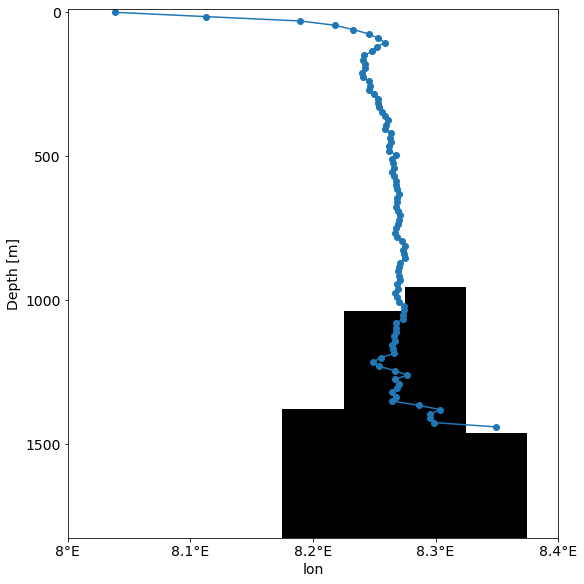

In [10]:
fig, ax = plt.subplots(1,1,figsize=(8,8),constrained_layout=True)

plt.plot(lon_values, -depth_values+INALT_levels.max().values, marker='o', linestyle='-')
plt.bar(np.linspace(0,18.05,362),topo_INALT_bar,width=0.05,label='INALT',color='black')

#labels
ax.set_xticks([8,8.1,8.2,8.3,8.4])
ax.set_xticklabels(['8°E','8.1°E','8.2°E','8.3°E','8.4°E'],fontsize=14, family='Arial')
ax.set_xlabel('lon',fontsize=14, family='Arial')
ax.set_ylabel('Depth [m]',fontsize=14, family='Arial')
ax.set_yticks(np.linspace(INALT_levels.max()-4000,INALT_levels.max(),9))
ax.set_yticklabels([int(i) for i in np.linspace(4000,0,9)],fontsize=14)
ax.invert_yaxis()
ax.set_xlim([8,8.4])
ax.set_ylim([4050,INALT_levels.max()+10])

plt.show()

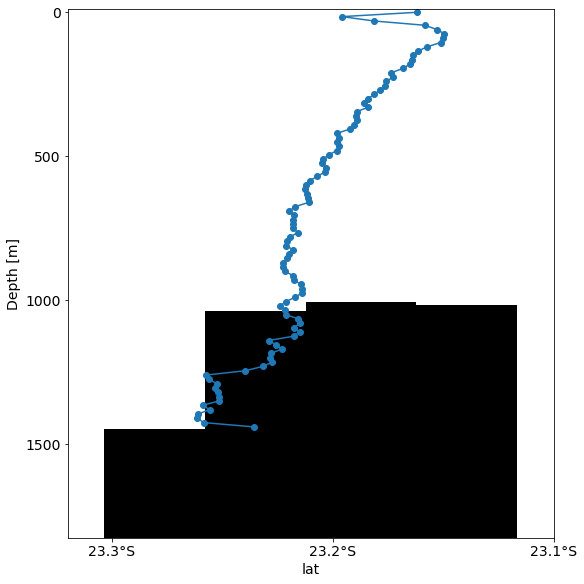

In [11]:
fig, ax = plt.subplots(1,1,figsize=(8,8),constrained_layout=True)

plt.plot(lat_values, -depth_values+INALT_levels.max().values, marker='o', linestyle='-')
plt.bar(np.linspace(-23.37,-23.05,8),topo_INALT_bar_meri,width=0.05,label='INALT',color='black')

#labels
ax.set_xticks([-23.3,-23.2,-23.1])
ax.set_xticklabels(['23.3°S','23.2°S','23.1°S'],fontsize=14, family='Arial')
ax.set_xlabel('lat',fontsize=14, family='Arial')
ax.set_ylabel('Depth [m]',fontsize=14, family='Arial')
ax.set_yticks(np.linspace(INALT_levels.max()-4000,INALT_levels.max(),9))
ax.set_yticklabels([int(i) for i in np.linspace(4000,0,9)],fontsize=14)
ax.invert_yaxis()
ax.set_xlim([-23.32,-23.1])
ax.set_ylim([4050,INALT_levels.max()+10])

plt.show()

In [13]:
dlon=1/111.32
lons = np.arange(6.9,10,dlon)
dlat= (1/(111.32*np.cos(np.deg2rad(-21)))+(1/(111.32*np.cos(np.deg2rad(-24)))))/2
lats = np.arange(-24.5,-21.5,dlat)

In [16]:
heat_map = xhist(particle_ds.lon, particle_ds.lat, bins=[lons, lats], dim=["traj", ])

In [17]:
heat_map_ROMS = xhist(ROMS_ds.lon, ROMS_ds.lat, bins=[lons, lats], dim=["traj", ])
heat_map_ROMSchild = xhist(ROMSchild_ds.lon, ROMSchild_ds.lat, bins=[lons, lats], dim=["traj", ])

In [18]:
%%time

INALT_SSL = particle_ds.where((particle_ds.isel(obs=0).depthdiff < 100), drop = True).compute() #& (particle_ds.isel(obs=0).depthdiff > 0)
ROMS_SSL = ROMS_ds.where((ROMS_ds.isel(obs=0).depthdiff < 100), drop = True).compute() # & (ROMS_ds.isel(obs=0).depthdiff > 0)
ROMSchild_SSL = ROMSchild_ds.where((ROMSchild_ds.isel(obs=0).depthdiff < 100), drop = True).compute() # & (ROMSchild_ds.isel(obs=0).depthdiff > 0)

CPU times: user 21.3 s, sys: 28 s, total: 49.3 s
Wall time: 2min 37s


In [19]:
heat_map_INALT_SSL = xhist(INALT_SSL.lon, INALT_SSL.lat, bins=[lons, lats], dim=["traj", ])
heat_map_ROMS_SSL = xhist(ROMS_SSL.lon, ROMS_SSL.lat, bins=[lons, lats], dim=["traj", ])
heat_map_ROMSchild_SSL = xhist(ROMSchild_SSL.lon, ROMSchild_SSL.lat, bins=[lons, lats], dim=["traj", ])

In [27]:
np.log10(heat_map_ROMSchild_SSL.values.max())

3.509336958017644

In [21]:
%%time

INALT_ML = particle_ds.where((particle_ds.isel(obs=0).z < 100), drop = True).compute()
ROMS_ML = ROMS_ds.where((ROMS_ds.isel(obs=0).z < 100), drop = True).compute()
ROMSchild_ML = ROMSchild_ds.where((ROMSchild_ds.isel(obs=0).z < 100), drop = True).compute()

CPU times: user 20 s, sys: 23.6 s, total: 43.6 s
Wall time: 2min 41s


In [22]:
heat_map_INALT_ML = xhist(INALT_ML.lon, INALT_ML.lat, bins=[lons, lats], dim=["traj", ])
heat_map_ROMS_ML = xhist(ROMS_ML.lon, ROMS_ML.lat, bins=[lons, lats], dim=["traj", ])
heat_map_ROMSchild_ML = xhist(ROMSchild_ML.lon, ROMSchild_ML.lat, bins=[lons, lats], dim=["traj", ])

In [25]:
np.log10(heat_map_ROMSchild_ML.isel(obs=10).values.max())

2.439332693830263

In [28]:
x = np.array([8.175, 8.325, 8.325, 8.375, 8.375, 8.325, 8.325, 8.225, 8.225, 8.175, 8.175])
y = np.array([-23.12069, -23.12069, -23.1666665, -23.1666665, -23.2585715, -23.2585715, -23.3045005, -23.3045005, -23.2585715, -23.2585715, -23.12069])

x_ROMS = np.array([8.1644115,8.1791175,8.1791175,8.193824,8.193824,
          8.2379415,8.2379415,8.267353,8.267353,8.3114705,8.3114705,
          8.355588,8.355588,8.370294,8.370294,8.4291175,8.4291175,
          8.4585295,8.4585295,8.4144115,8.4144115,8.385,8.385,8.370294,
          8.370294,8.355588,8.355588,8.340882,8.340882,8.3261765,8.3261765,
          8.3114705,8.3114705,8.282059,8.282059,8.223235,8.223235,8.2085295,
          8.2085295,8.193824,8.193824,8.1791175,8.1791175,8.1644115,8.1644115])
y_ROMS = np.array([-23.1675815,-23.1675815,-23.14054,-23.14054,-23.127018,-23.127018,
          -23.14054,-23.14054,-23.154061,-23.154061,-23.1675815,-23.1675815,
          -23.1811,-23.1811,-23.1675815,-23.1675815,-23.1811,-23.1811,-23.2081335,
          -23.2081335,-23.221648,-23.221648,-23.235161,-23.235161,-23.2486725,-23.2486725,
          -23.275692,-23.275692,-23.316211,-23.316211,-23.343217,-23.343217,-23.329715,
          -23.329715,-23.316211,-23.316211,-23.302706,-23.302706,-23.2892,-23.2892,
          -23.235161,-23.235161,-23.2081335,-23.2081335,-23.1675815])

In [29]:
original_cmap = plt.cm.Blues
original_colors = original_cmap(np.linspace(0, 1, 1000))
new_cmap = original_cmap#ListedColormap(original_colors[int(0.2 * len(original_colors)):])

In [30]:
original_cmap_bathy = plt.cm.Greys_r
original_colors_bathy = original_cmap_bathy(np.linspace(0, 1, 1000))
new_cmap_bathy = ListedColormap(original_colors_bathy[:(int(0.8 * len(original_colors_bathy)))])

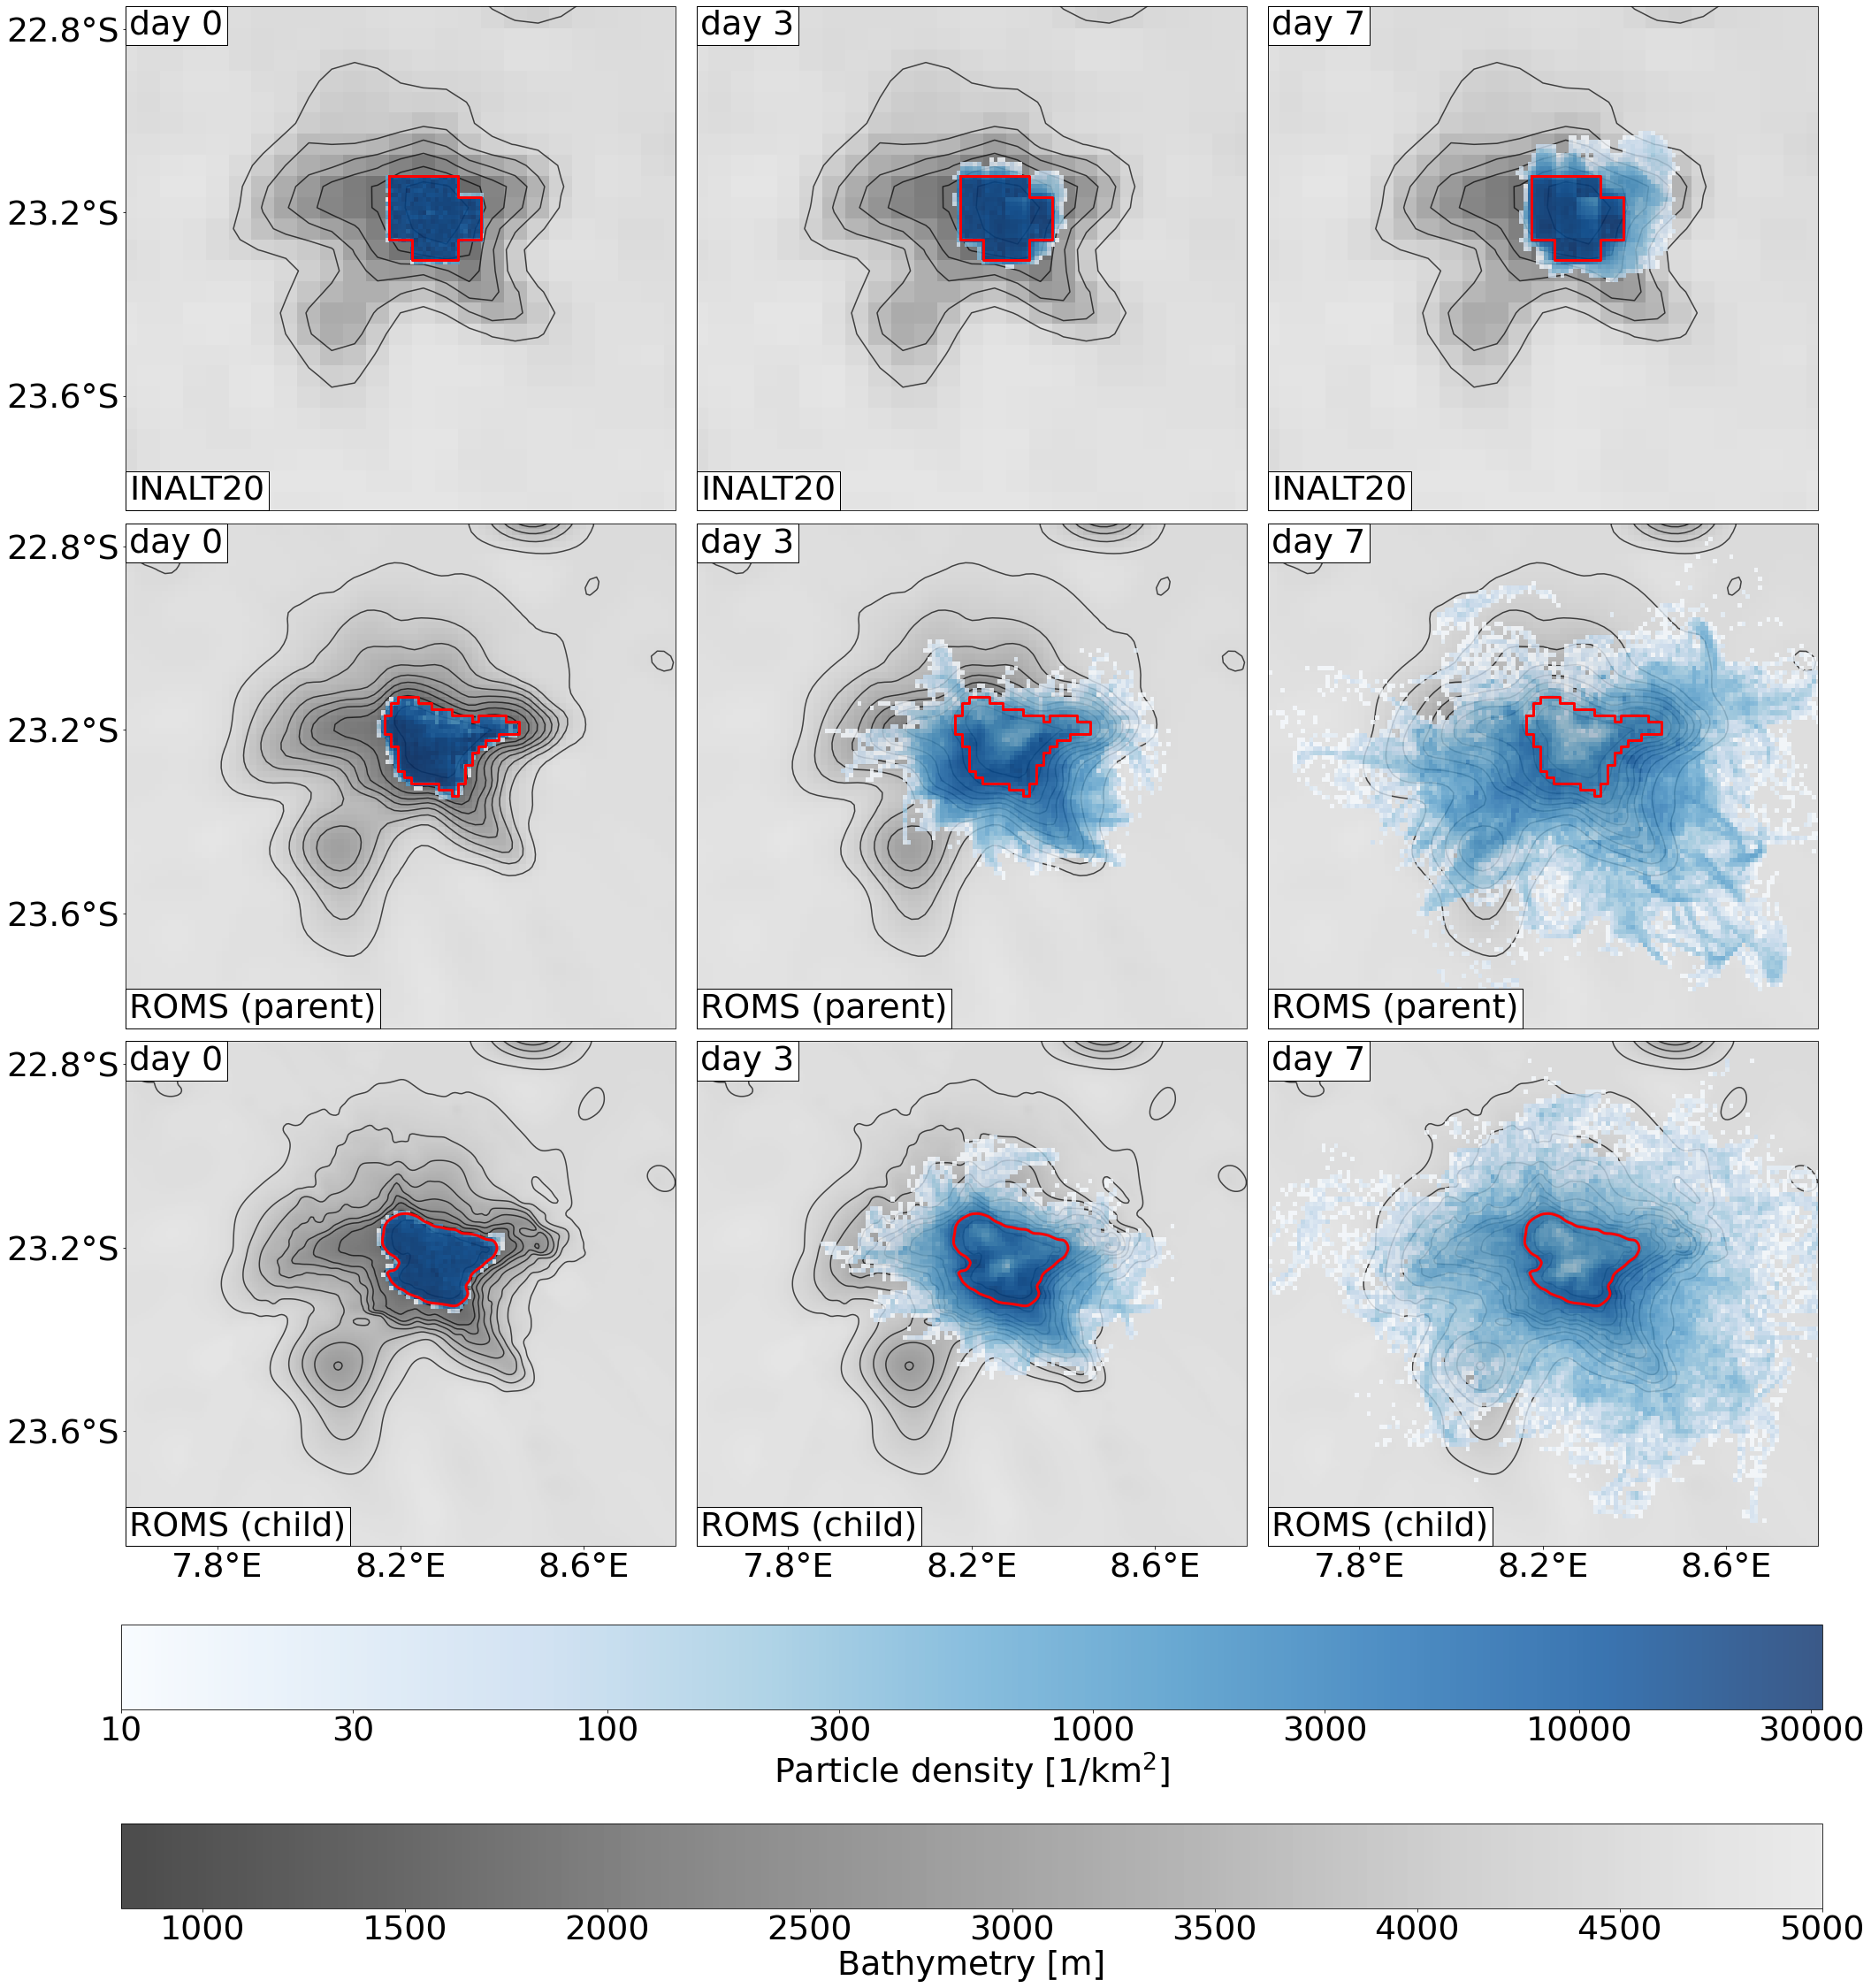

In [33]:
plt.rcParams.update({'font.size': 38})
linewidth_red = 3

fig, ([ax1, ax4, ax7], [ax2, ax5, ax8], [ax3, ax6, ax9]) = plt.subplots(3,3,figsize=(30,31),constrained_layout=True,
                      subplot_kw=dict(projection=ccrs.PlateCarree()))

ax1.set_extent([7.6,8.8,
               -23.85,-22.75], crs=ccrs.PlateCarree())
cf=ax1.pcolormesh(INALT_mask.glamt[0,0,:],INALT_mask.gphit[0,:,0],
             topo_INALT,vmin=800,vmax=5000,#levels=22,
             alpha=0.7,zorder=0,cmap=new_cmap_bathy)
c=ax1.contour(INALT_mask.glamt[0,0,:],INALT_mask.gphit[0,:,0],
             topo_INALT,vmin=1000,vmax=5500,levels=10,
             alpha=0.7,zorder=1,colors='black')
cfh=ax1.pcolormesh(heat_map.lon_bin,heat_map.lat_bin,np.log10(heat_map_INALT_SSL.isel(obs=0).T),cmap=new_cmap,zorder=2,alpha=0.8,vmax=3.5)#,levels=np.linspace(0,3.5,8))
ax1.plot(x, y, color='red',linewidth=linewidth_red)

ax1.set_xticks([])
ax1.set_yticks([-23.6,-23.2,-22.8])
ax1.set_yticklabels(['23.6°S', '23.2°S', '22.8°S'])

ax1.text(*(7.609, -23.842),'INALT20', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))
ax1.text(*(7.609, -22.758),'day 0', ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black'))

############################################################################

ax2.set_extent([7.6,8.8,
               -23.85,-22.75], crs=ccrs.PlateCarree())
cf=ax2.pcolormesh(SIGMA.lon_rho,SIGMA.lat_rho,SIGMA.h,
                vmin=800,vmax=5000,alpha=0.7,zorder=0,cmap=new_cmap_bathy)
c=ax2.contour(SIGMA.lon_rho,SIGMA.lat_rho,SIGMA.h,
              vmin=1000,vmax=5500,levels=10,alpha=0.7,zorder=1,colors='black')
cfh=ax2.pcolormesh(heat_map_ROMS.lon_bin,heat_map_ROMS.lat_bin,np.log10(heat_map_ROMS_SSL.isel(obs=0).T),cmap=new_cmap,zorder=2,alpha=0.8,vmax=3.5)#,levels=np.linspace(0,3.5,8))
ax2.plot(x_ROMS, y_ROMS, color='red',linewidth=linewidth_red)

ax2.set_xticks([])
ax2.set_yticks([-23.6,-23.2,-22.8])
ax2.set_yticklabels(['23.6°S', '23.2°S', '22.8°S'])

ax2.text(*(7.609, -23.842),'ROMS (parent)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))
ax2.text(*(7.609, -22.758),'day 0', ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black'))

############################################################################

ax3.set_extent([7.6,8.8,
               -23.85,-22.75], crs=ccrs.PlateCarree())
cf=ax3.pcolormesh(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
                vmin=800,vmax=5000,alpha=0.7,zorder=0,cmap=new_cmap_bathy)
c=ax3.contour(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
              vmin=1000,vmax=5500,levels=10,alpha=0.7,zorder=1,colors='black')
cfh=ax3.pcolormesh(heat_map_ROMSchild.lon_bin,heat_map_ROMSchild.lat_bin,np.log10(heat_map_ROMSchild_SSL.isel(obs=0).T),cmap=new_cmap,zorder=2,alpha=0.8,vmax=3.5)#,levels=np.linspace(0,3.5,8))
ax3.contour(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
              levels=[1500],zorder=3,colors='red',linewidths=linewidth_red)

ax3.set_xticks([7.8,8.2,8.6])
ax3.set_xticklabels(['7.8°E','8.2°E','8.6°E'])
ax3.set_yticks([-23.6,-23.2,-22.8])
ax3.set_yticklabels(['23.6°S', '23.2°S', '22.8°S'])

ax3.text(*(7.609, -23.842),'ROMS (child)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))
ax3.text(*(7.609, -22.758),'day 0', ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black'))

############################################################################

ax4.set_extent([7.6,8.8,
               -23.85,-22.75], crs=ccrs.PlateCarree())
cf=ax4.pcolormesh(INALT_mask.glamt[0,0,:],INALT_mask.gphit[0,:,0],
             topo_INALT,vmin=800,vmax=5000,#levels=22,
             alpha=0.7,zorder=0,cmap=new_cmap_bathy)
c=ax4.contour(INALT_mask.glamt[0,0,:],INALT_mask.gphit[0,:,0],
             topo_INALT,vmin=1000,vmax=5500,levels=10,
             alpha=0.7,zorder=1,colors='black')
cfh=ax4.pcolormesh(heat_map.lon_bin,heat_map.lat_bin,np.log10(heat_map_INALT_SSL.isel(obs=3).T),cmap=new_cmap,zorder=2,alpha=0.8,vmax=3.5)#,levels=np.linspace(0,3.5,8))
ax4.plot(x, y, color='red',linewidth=linewidth_red)

ax4.set_xticks([])
ax4.set_yticks([])

ax4.text(*(7.609, -23.842),'INALT20', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))
ax4.text(*(7.609, -22.758),'day 3', ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black'))

############################################################################

ax5.set_extent([7.6,8.8,
               -23.85,-22.75], crs=ccrs.PlateCarree())
cf=ax5.pcolormesh(SIGMA.lon_rho,SIGMA.lat_rho,SIGMA.h,
                vmin=800,vmax=5000,alpha=0.7,zorder=0,cmap=new_cmap_bathy)
c=ax5.contour(SIGMA.lon_rho,SIGMA.lat_rho,SIGMA.h,
              vmin=1000,vmax=5500,levels=10,alpha=0.7,zorder=1,colors='black')
cfh=ax5.pcolormesh(heat_map_ROMS.lon_bin,heat_map_ROMS.lat_bin,np.log10(heat_map_ROMS_SSL.isel(obs=3).T),cmap=new_cmap,zorder=2,alpha=0.8,vmax=3.5)#,levels=np.linspace(0,3.5,8))
ax5.plot(x_ROMS, y_ROMS, color='red',linewidth=linewidth_red)

ax5.set_xticks([])
ax5.set_yticks([])

ax5.text(*(7.609, -23.842),'ROMS (parent)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))
ax5.text(*(7.609, -22.758),'day 3', ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black'))

############################################################################

ax6.set_extent([7.6,8.8,
               -23.85,-22.75], crs=ccrs.PlateCarree())
cf=ax6.pcolormesh(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
                vmin=800,vmax=5000,alpha=0.7,zorder=0,cmap=new_cmap_bathy)
c=ax6.contour(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
              vmin=1000,vmax=5500,levels=10,alpha=0.7,zorder=1,colors='black')
cfh=ax6.pcolormesh(heat_map_ROMSchild.lon_bin,heat_map_ROMSchild.lat_bin,np.log10(heat_map_ROMSchild_SSL.isel(obs=3).T),cmap=new_cmap,zorder=2,alpha=0.8,vmax=3.5)#,levels=np.linspace(0,3.5,8))
ax6.contour(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
              levels=[1500],zorder=3,colors='red',linewidths=linewidth_red)

ax6.set_xticks([7.8,8.2,8.6])
ax6.set_xticklabels(['7.8°E','8.2°E','8.6°E'])
ax6.set_yticks([])

ax6.text(*(7.609, -23.842),'ROMS (child)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))
ax6.text(*(7.609, -22.758),'day 3', ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black'))

#############################################################################

ax7.set_extent([7.6,8.8,
               -23.85,-22.75], crs=ccrs.PlateCarree())
cf=ax7.pcolormesh(INALT_mask.glamt[0,0,:],INALT_mask.gphit[0,:,0],
             topo_INALT,vmin=800,vmax=5000,#levels=22,
             alpha=0.7,zorder=0,cmap=new_cmap_bathy)
c=ax7.contour(INALT_mask.glamt[0,0,:],INALT_mask.gphit[0,:,0],
             topo_INALT,vmin=1000,vmax=5500,levels=10,
             alpha=0.7,zorder=1,colors='black')
cfh=ax7.pcolormesh(heat_map.lon_bin,heat_map.lat_bin,np.log10(heat_map_INALT_SSL.isel(obs=7).T),cmap=new_cmap,zorder=2,alpha=0.8,vmax=3.5)#,levels=np.linspace(0,3.5,8))
ax7.plot(x, y, color='red',linewidth=linewidth_red)

ax7.set_xticks([])
ax7.set_yticks([])

ax7.text(*(7.609, -23.842),'INALT20', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))
ax7.text(*(7.609, -22.758),'day 7', ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black'))

############################################################################

ax8.set_extent([7.6,8.8,
               -23.85,-22.75], crs=ccrs.PlateCarree())
cf=ax8.pcolormesh(SIGMA.lon_rho,SIGMA.lat_rho,SIGMA.h,
                vmin=800,vmax=5000,alpha=0.7,zorder=0,cmap=new_cmap_bathy)
c=ax8.contour(SIGMA.lon_rho,SIGMA.lat_rho,SIGMA.h,
              vmin=1000,vmax=5500,levels=10,alpha=0.7,zorder=1,colors='black')
cfh=ax8.pcolormesh(heat_map_ROMS.lon_bin,heat_map_ROMS.lat_bin,np.log10(heat_map_ROMS_SSL.isel(obs=7).T),cmap=new_cmap,zorder=2,alpha=0.8,vmax=3.5)#,levels=np.linspace(0,3.5,8))
ax8.plot(x_ROMS, y_ROMS, color='red',linewidth=linewidth_red)

ax8.set_xticks([])
ax8.set_yticks([])

ax8.text(*(7.609, -23.842),'ROMS (parent)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))
ax8.text(*(7.609, -22.758),'day 7', ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black'))

############################################################################

ax9.set_extent([7.6,8.8,
               -23.85,-22.75], crs=ccrs.PlateCarree())
cf=ax9.pcolormesh(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
                vmin=800,vmax=5000,alpha=0.7,zorder=0,cmap=new_cmap_bathy)
c=ax9.contour(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
              vmin=1000,vmax=5500,levels=10,alpha=0.7,zorder=1,colors='black')
cfh=ax9.pcolormesh(heat_map_ROMSchild.lon_bin,heat_map_ROMSchild.lat_bin,np.log10(heat_map_ROMSchild_SSL.isel(obs=7).T),cmap=new_cmap,zorder=2,alpha=0.8,vmax=3.5)#,levels=np.linspace(0,3.5,8))
ax9.contour(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
              levels=[1500],zorder=3,colors='red',linewidths=linewidth_red)

ax9.set_xticks([7.8,8.2,8.6])
ax9.set_xticklabels(['7.8°E','8.2°E','8.6°E'])
ax9.set_yticks([])
ax9.text(*(7.609, -23.842),'ROMS (child)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))
ax9.text(*(7.609, -22.758),'day 7', ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black'))


cb=plt.colorbar(cf, ax=[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9], orientation='horizontal', pad=0.02)
cb.set_label('Bathymetry [m]')
cb_contourf = plt.colorbar(cfh, ax=[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9], orientation='horizontal', pad=0.02)
cb_contourf.set_label('Particle density [1/km$^2$]')
cb_contourf.set_ticks([0,0.4771212547196624,1,1.4771212547196624,2,2.4771212547196624,3,3.4771212547196624])
cb_contourf.set_ticklabels([10,30,100,300,1000,3000,10000,30000])

plt.savefig('../output_data/heatmaps_SSL.png', bbox_inches='tight')

plt.show()

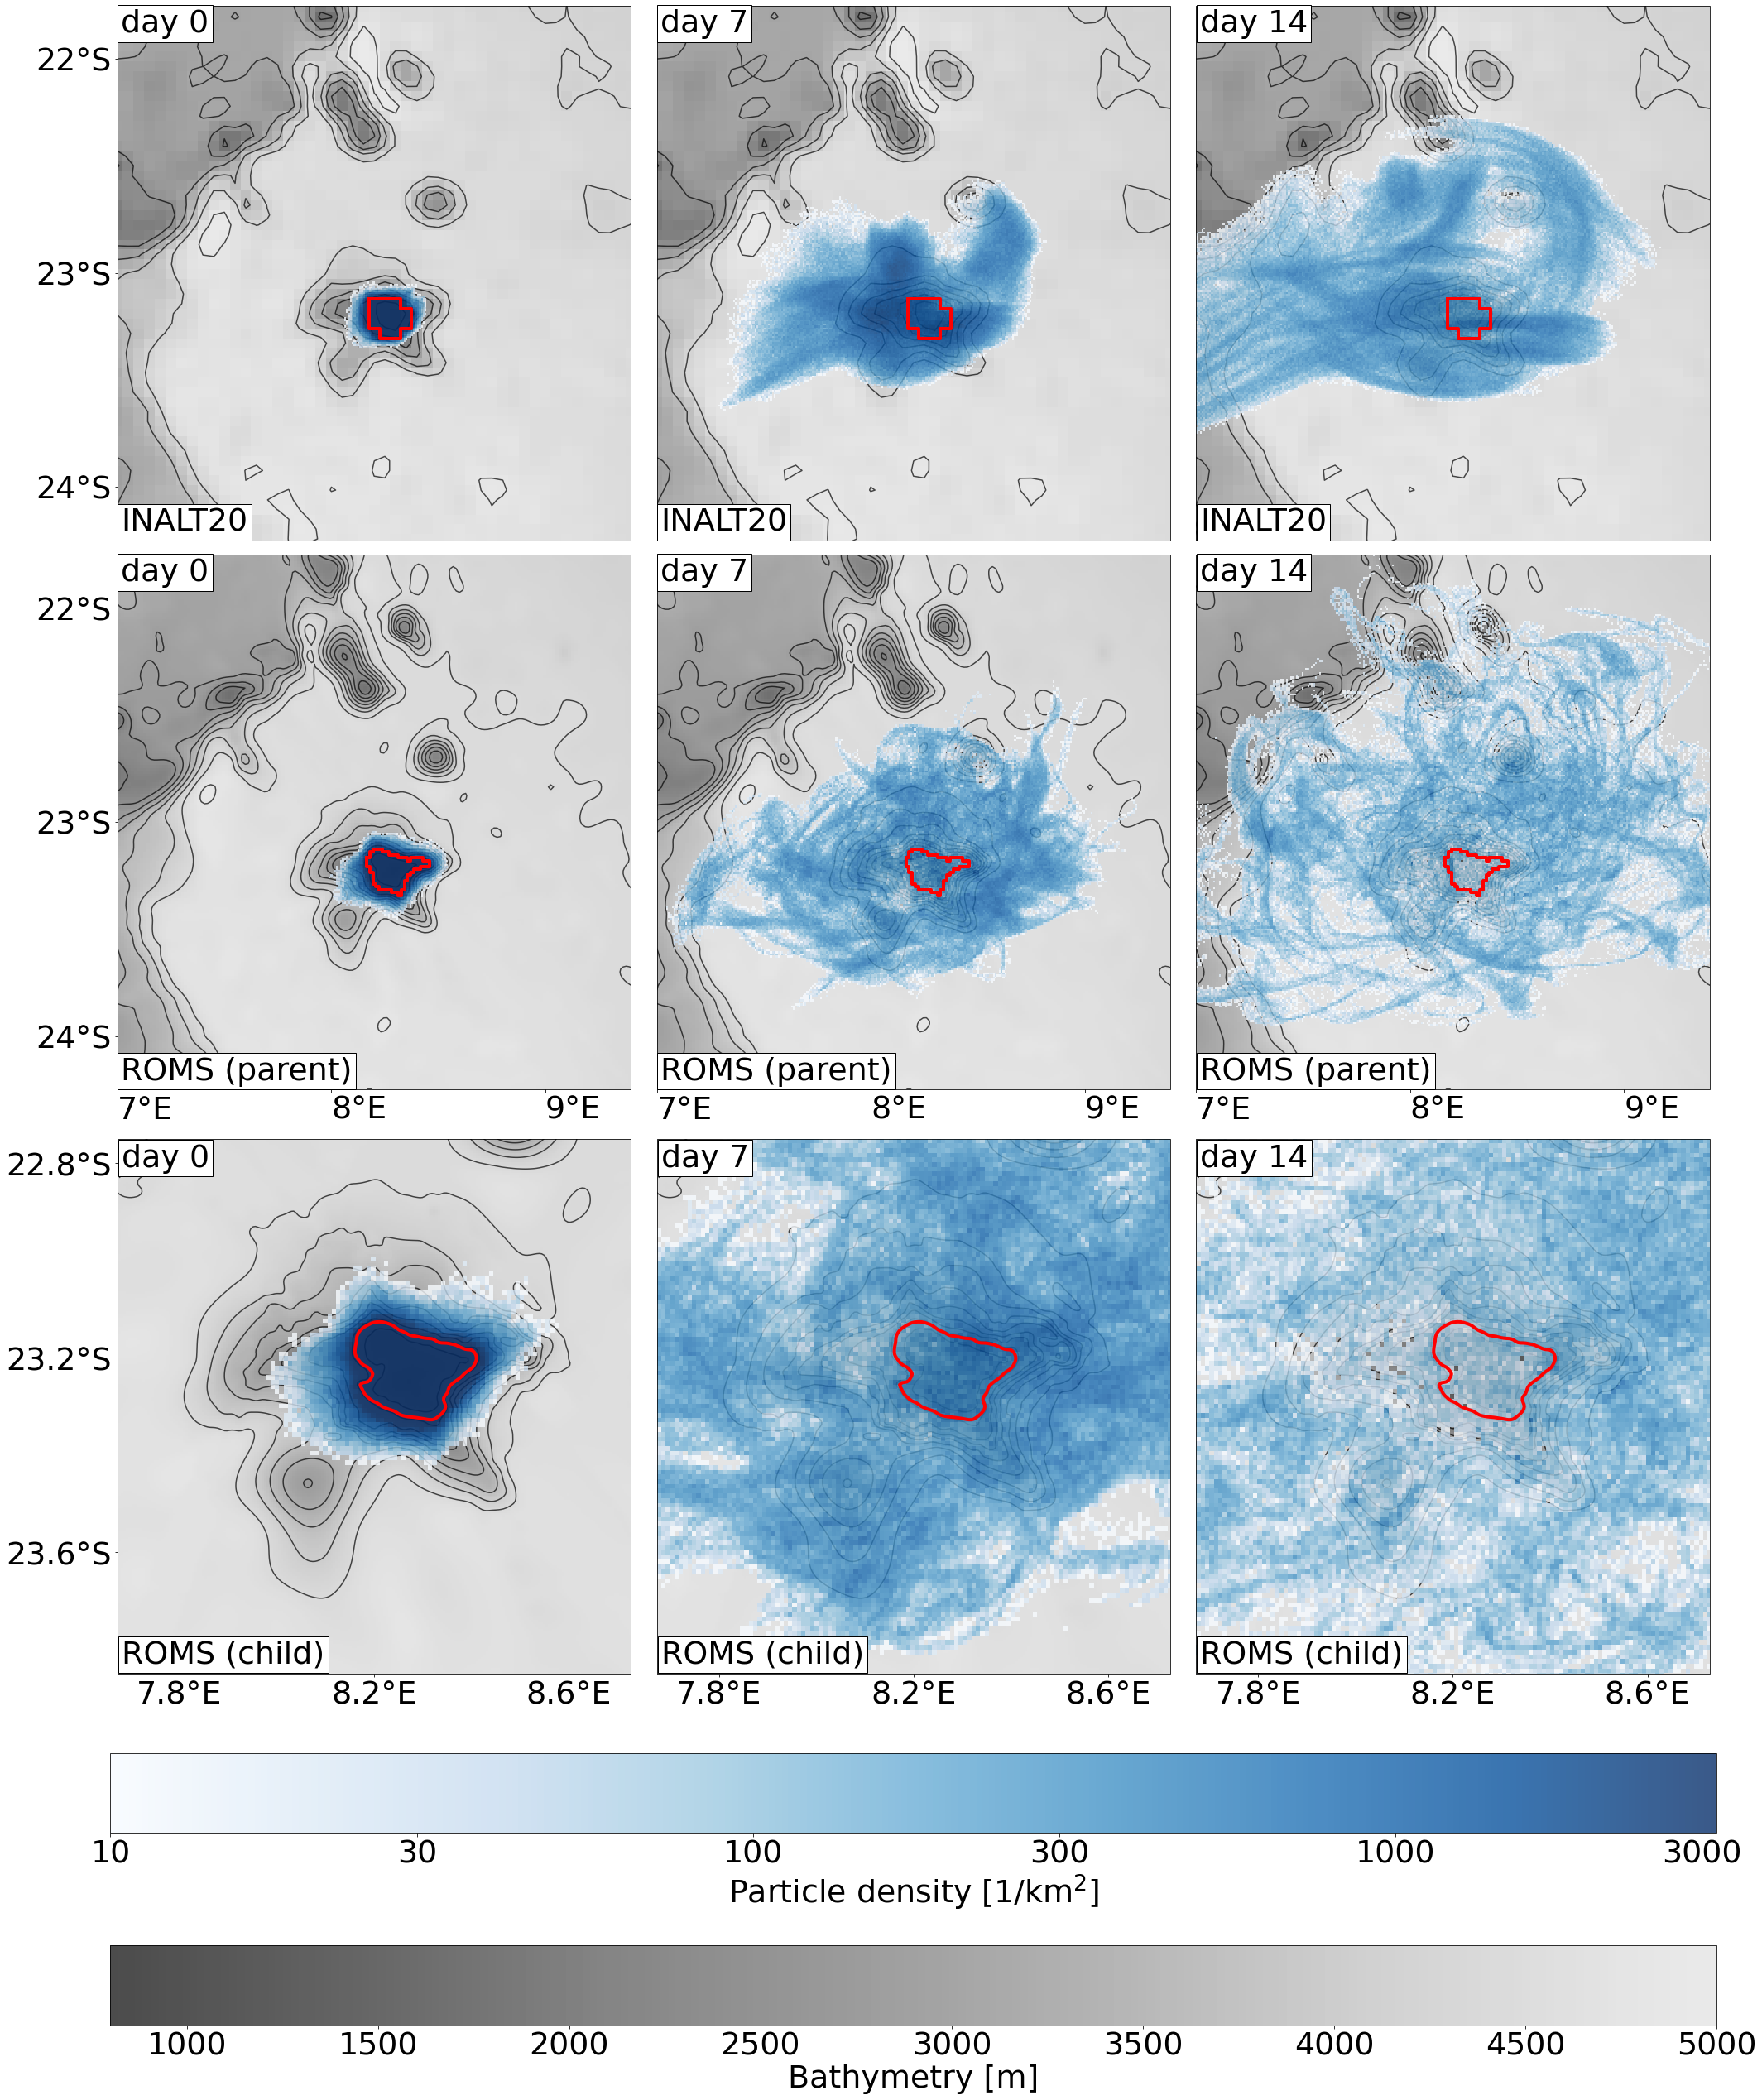

In [38]:
plt.rcParams.update({'font.size': 38})
linewidth_red = 4
extent = [7,9.4, -24.25,-21.75]
obs_1 = 7
obs_2 = 14
text_day = [7.018, -21.765]
text_model = [7.018, -24.235]

fig, ([ax1, ax4, ax7], [ax2, ax5, ax8], [ax3, ax6, ax9]) = plt.subplots(3,3,figsize=(30,35),constrained_layout=True,
                      subplot_kw=dict(projection=ccrs.PlateCarree()))

ax1.set_extent(extent, crs=ccrs.PlateCarree())
cf=ax1.pcolormesh(INALT_mask.glamt[0,0,:],INALT_mask.gphit[0,:,0],
             topo_INALT,vmin=800,vmax=5000,#levels=22,
             alpha=0.7,zorder=0,cmap=new_cmap_bathy)
c=ax1.contour(INALT_mask.glamt[0,0,:],INALT_mask.gphit[0,:,0],
             topo_INALT,vmin=1000,vmax=5500,levels=10,
             alpha=0.7,zorder=1,colors='black')
cfh=ax1.pcolormesh(heat_map.lon_bin,heat_map.lat_bin,np.log10(heat_map_INALT_ML.isel(obs=0).T),cmap=new_cmap,zorder=2,alpha=0.8,vmax=2.5)#,levels=np.linspace(0,3.5,8))
ax1.plot(x, y, color='red',linewidth=linewidth_red)

ax1.set_xticks([])
ax1.set_yticks([-24,-23,-22])
ax1.set_yticklabels(['24°S', '23°S', '22°S'])

ax1.text(*(text_model),'INALT20', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))
ax1.text(*(text_day),'day 0', ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black'))

############################################################################

ax2.set_extent(extent, crs=ccrs.PlateCarree())
cf=ax2.pcolormesh(SIGMA.lon_rho,SIGMA.lat_rho,SIGMA.h,
                vmin=800,vmax=5000,alpha=0.7,zorder=0,cmap=new_cmap_bathy)
c=ax2.contour(SIGMA.lon_rho,SIGMA.lat_rho,SIGMA.h,
              vmin=1000,vmax=5500,levels=10,alpha=0.7,zorder=1,colors='black')
cfh=ax2.pcolormesh(heat_map_ROMS.lon_bin,heat_map_ROMS.lat_bin,np.log10(heat_map_ROMS_ML.isel(obs=0).T),cmap=new_cmap,zorder=2,alpha=0.8,vmax=2.5)#,levels=np.linspace(0,3.5,8))
ax2.plot(x_ROMS, y_ROMS, color='red',linewidth=linewidth_red)

ax2.set_xticks([7,8,9])
ax2.set_xticklabels(['7°E','8°E','9°E'],ha='left')
ax2.set_yticks([-24,-23,-22])
ax2.set_yticklabels(['24°S', '23°S', '22°S'])

ax2.text(*(text_model),'ROMS (parent)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))
ax2.text(*(text_day),'day 0', ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black'))


############################################################################

ax4.set_extent(extent, crs=ccrs.PlateCarree())
cf=ax4.pcolormesh(INALT_mask.glamt[0,0,:],INALT_mask.gphit[0,:,0],
             topo_INALT,vmin=800,vmax=5000,#levels=22,
             alpha=0.7,zorder=0,cmap=new_cmap_bathy)
c=ax4.contour(INALT_mask.glamt[0,0,:],INALT_mask.gphit[0,:,0],
             topo_INALT,vmin=1000,vmax=5500,levels=10,
             alpha=0.7,zorder=1,colors='black')
cfh=ax4.pcolormesh(heat_map.lon_bin,heat_map.lat_bin,np.log10(heat_map_INALT_ML.isel(obs=obs_1).T),cmap=new_cmap,zorder=2,alpha=0.8,vmax=2.5)#,levels=np.linspace(0,3.5,8))
ax4.plot(x, y, color='red',linewidth=linewidth_red)

ax4.set_xticks([])
ax4.set_yticks([])

ax4.text(*(text_model),'INALT20', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))
ax4.text(*(text_day),f'day {obs_1}', ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black'))

############################################################################

ax5.set_extent(extent, crs=ccrs.PlateCarree())
cf=ax5.pcolormesh(SIGMA.lon_rho,SIGMA.lat_rho,SIGMA.h,
                vmin=800,vmax=5000,alpha=0.7,zorder=0,cmap=new_cmap_bathy)
c=ax5.contour(SIGMA.lon_rho,SIGMA.lat_rho,SIGMA.h,
              vmin=1000,vmax=5500,levels=10,alpha=0.7,zorder=1,colors='black')
cfh=ax5.pcolormesh(heat_map_ROMS.lon_bin,heat_map_ROMS.lat_bin,np.log10(heat_map_ROMS_ML.isel(obs=obs_1).T),cmap=new_cmap,zorder=2,alpha=0.8,vmax=2.5)#,levels=np.linspace(0,3.5,8))
ax5.plot(x_ROMS, y_ROMS, color='red',linewidth=linewidth_red)

ax5.set_xticks([7,8,9])
ax5.set_xticklabels(['7°E','8°E','9°E'],ha='left')
ax5.set_yticks([])

ax5.text(*(text_model),'ROMS (parent)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))
ax5.text(*(text_day),f'day {obs_1}', ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black'))

#############################################################################

ax7.set_extent(extent, crs=ccrs.PlateCarree())
cf=ax7.pcolormesh(INALT_mask.glamt[0,0,:],INALT_mask.gphit[0,:,0],
             topo_INALT,vmin=800,vmax=5000,#levels=22,
             alpha=0.7,zorder=0,cmap=new_cmap_bathy)
c=ax7.contour(INALT_mask.glamt[0,0,:],INALT_mask.gphit[0,:,0],
             topo_INALT,vmin=1000,vmax=5500,levels=10,
             alpha=0.7,zorder=1,colors='black')
cfh=ax7.pcolormesh(heat_map.lon_bin,heat_map.lat_bin,np.log10(heat_map_INALT_ML.isel(obs=obs_2).T),cmap=new_cmap,zorder=2,alpha=0.8,vmax=2.5)#,levels=np.linspace(0,3.5,8))
ax7.plot(x, y, color='red',linewidth=linewidth_red)

ax7.set_xticks([])
ax7.set_yticks([])

ax7.text(*(text_model),'INALT20', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))
ax7.text(*(text_day),f'day {obs_2}', ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black'))

############################################################################

ax8.set_extent(extent, crs=ccrs.PlateCarree())
cf=ax8.pcolormesh(SIGMA.lon_rho,SIGMA.lat_rho,SIGMA.h,
                vmin=800,vmax=5000,alpha=0.7,zorder=0,cmap=new_cmap_bathy)
c=ax8.contour(SIGMA.lon_rho,SIGMA.lat_rho,SIGMA.h,
              vmin=1000,vmax=5500,levels=10,alpha=0.7,zorder=1,colors='black')
cfh=ax8.pcolormesh(heat_map_ROMS.lon_bin,heat_map_ROMS.lat_bin,np.log10(heat_map_ROMS_ML.isel(obs=obs_2).T),cmap=new_cmap,zorder=2,alpha=0.8,vmax=2.5)#,levels=np.linspace(0,3.5,8))
ax8.plot(x_ROMS, y_ROMS, color='red',linewidth=linewidth_red)

ax8.set_xticks([7,8,9])
ax8.set_xticklabels(['7°E','8°E','9°E'],ha='left')
ax8.set_yticks([])

ax8.text(*(text_model),'ROMS (parent)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))
ax8.text(*(text_day),f'day {obs_2}', ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black'))


##########################################################################################
##########################################################################################

ax3.set_extent([7.672,8.728,
               -23.85,-22.75], crs=ccrs.PlateCarree())
cf=ax3.pcolormesh(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
                vmin=800,vmax=5000,alpha=0.7,zorder=0,cmap=new_cmap_bathy)
c=ax3.contour(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
              vmin=1000,vmax=5500,levels=10,alpha=0.7,zorder=1,colors='black')
cfh=ax3.pcolormesh(heat_map_ROMSchild.lon_bin,heat_map_ROMSchild.lat_bin,np.log10(heat_map_ROMSchild_ML.isel(obs=0).T),cmap=new_cmap,zorder=2,alpha=0.8,vmax=2.5)#,levels=np.linspace(0,3.5,8))
ax3.contour(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
              levels=[1500],zorder=3,colors='red',linewidths=linewidth_red)

ax3.set_xticks([7.8,8.2,8.6])
ax3.set_xticklabels(['7.8°E','8.2°E','8.6°E'])
ax3.set_yticks([-23.6,-23.2,-22.8])
ax3.set_yticklabels(['23.6°S', '23.2°S', '22.8°S'])

ax3.text(*(7.681, -23.841),'ROMS (child)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))
ax3.text(*(7.681, -22.759),'day 0', ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black'))

############################################################################

ax6.set_extent([7.672,8.728,
               -23.85,-22.75], crs=ccrs.PlateCarree())
cf=ax6.pcolormesh(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
                vmin=800,vmax=5000,alpha=0.7,zorder=0,cmap=new_cmap_bathy)
c=ax6.contour(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
              vmin=1000,vmax=5500,levels=10,alpha=0.7,zorder=1,colors='black')
cfh=ax6.pcolormesh(heat_map_ROMSchild.lon_bin,heat_map_ROMSchild.lat_bin,np.log10(heat_map_ROMSchild_ML.isel(obs=obs_1).T),cmap=new_cmap,zorder=2,alpha=0.8,vmax=2.5)#,levels=np.linspace(0,3.5,8))
ax6.contour(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
              levels=[1500],zorder=3,colors='red',linewidths=linewidth_red)

ax6.set_xticks([7.8,8.2,8.6])
ax6.set_xticklabels(['7.8°E','8.2°E','8.6°E'])
ax6.set_yticks([])

ax6.text(*(7.681, -23.841),'ROMS (child)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))
ax6.text(*(7.681, -22.759),f'day {obs_1}', ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black'))

############################################################################

ax9.set_extent([7.672,8.728,
               -23.85,-22.75], crs=ccrs.PlateCarree())
cf=ax9.pcolormesh(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
                vmin=800,vmax=5000,alpha=0.7,zorder=0,cmap=new_cmap_bathy)
c=ax9.contour(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
              vmin=1000,vmax=5500,levels=10,alpha=0.7,zorder=1,colors='black')
cfh=ax9.pcolormesh(heat_map_ROMSchild.lon_bin,heat_map_ROMSchild.lat_bin,np.log10(heat_map_ROMSchild_ML.isel(obs=obs_2).T),cmap=new_cmap,zorder=2,alpha=0.8,vmax=2.5)#,levels=np.linspace(0,3.5,8))
ax9.contour(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
              levels=[1500],zorder=3,colors='red',linewidths=linewidth_red)

ax9.set_xticks([7.8,8.2,8.6])
ax9.set_xticklabels(['7.8°E','8.2°E','8.6°E'])
ax9.set_yticks([])
ax9.text(*(7.681, -23.841),'ROMS (child)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))
ax9.text(*(7.681, -22.759),f'day {obs_2}', ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black'))

################################################################################
################################################################################

cb=plt.colorbar(cf, ax=[ax1, ax2, ax4, ax5, ax7, ax8, ax3,ax6,ax9], orientation='horizontal', pad=0.02)
cb.set_label('Bathymetry [m]')
cb_contourf = plt.colorbar(cfh, ax=[ax1, ax2, ax4, ax5, ax7, ax8, ax3,ax6,ax9], orientation='horizontal', pad=0.02)
cb_contourf.set_label('Particle density [1/km$^2$]')
cb_contourf.set_ticks([0,0.4771212547196624,1,1.4771212547196624,2,2.4771212547196624])
cb_contourf.set_ticklabels([10,30,100,300,1000,3000])

plt.savefig('../output_data/heatmaps_ML.png', bbox_inches='tight')

plt.show()

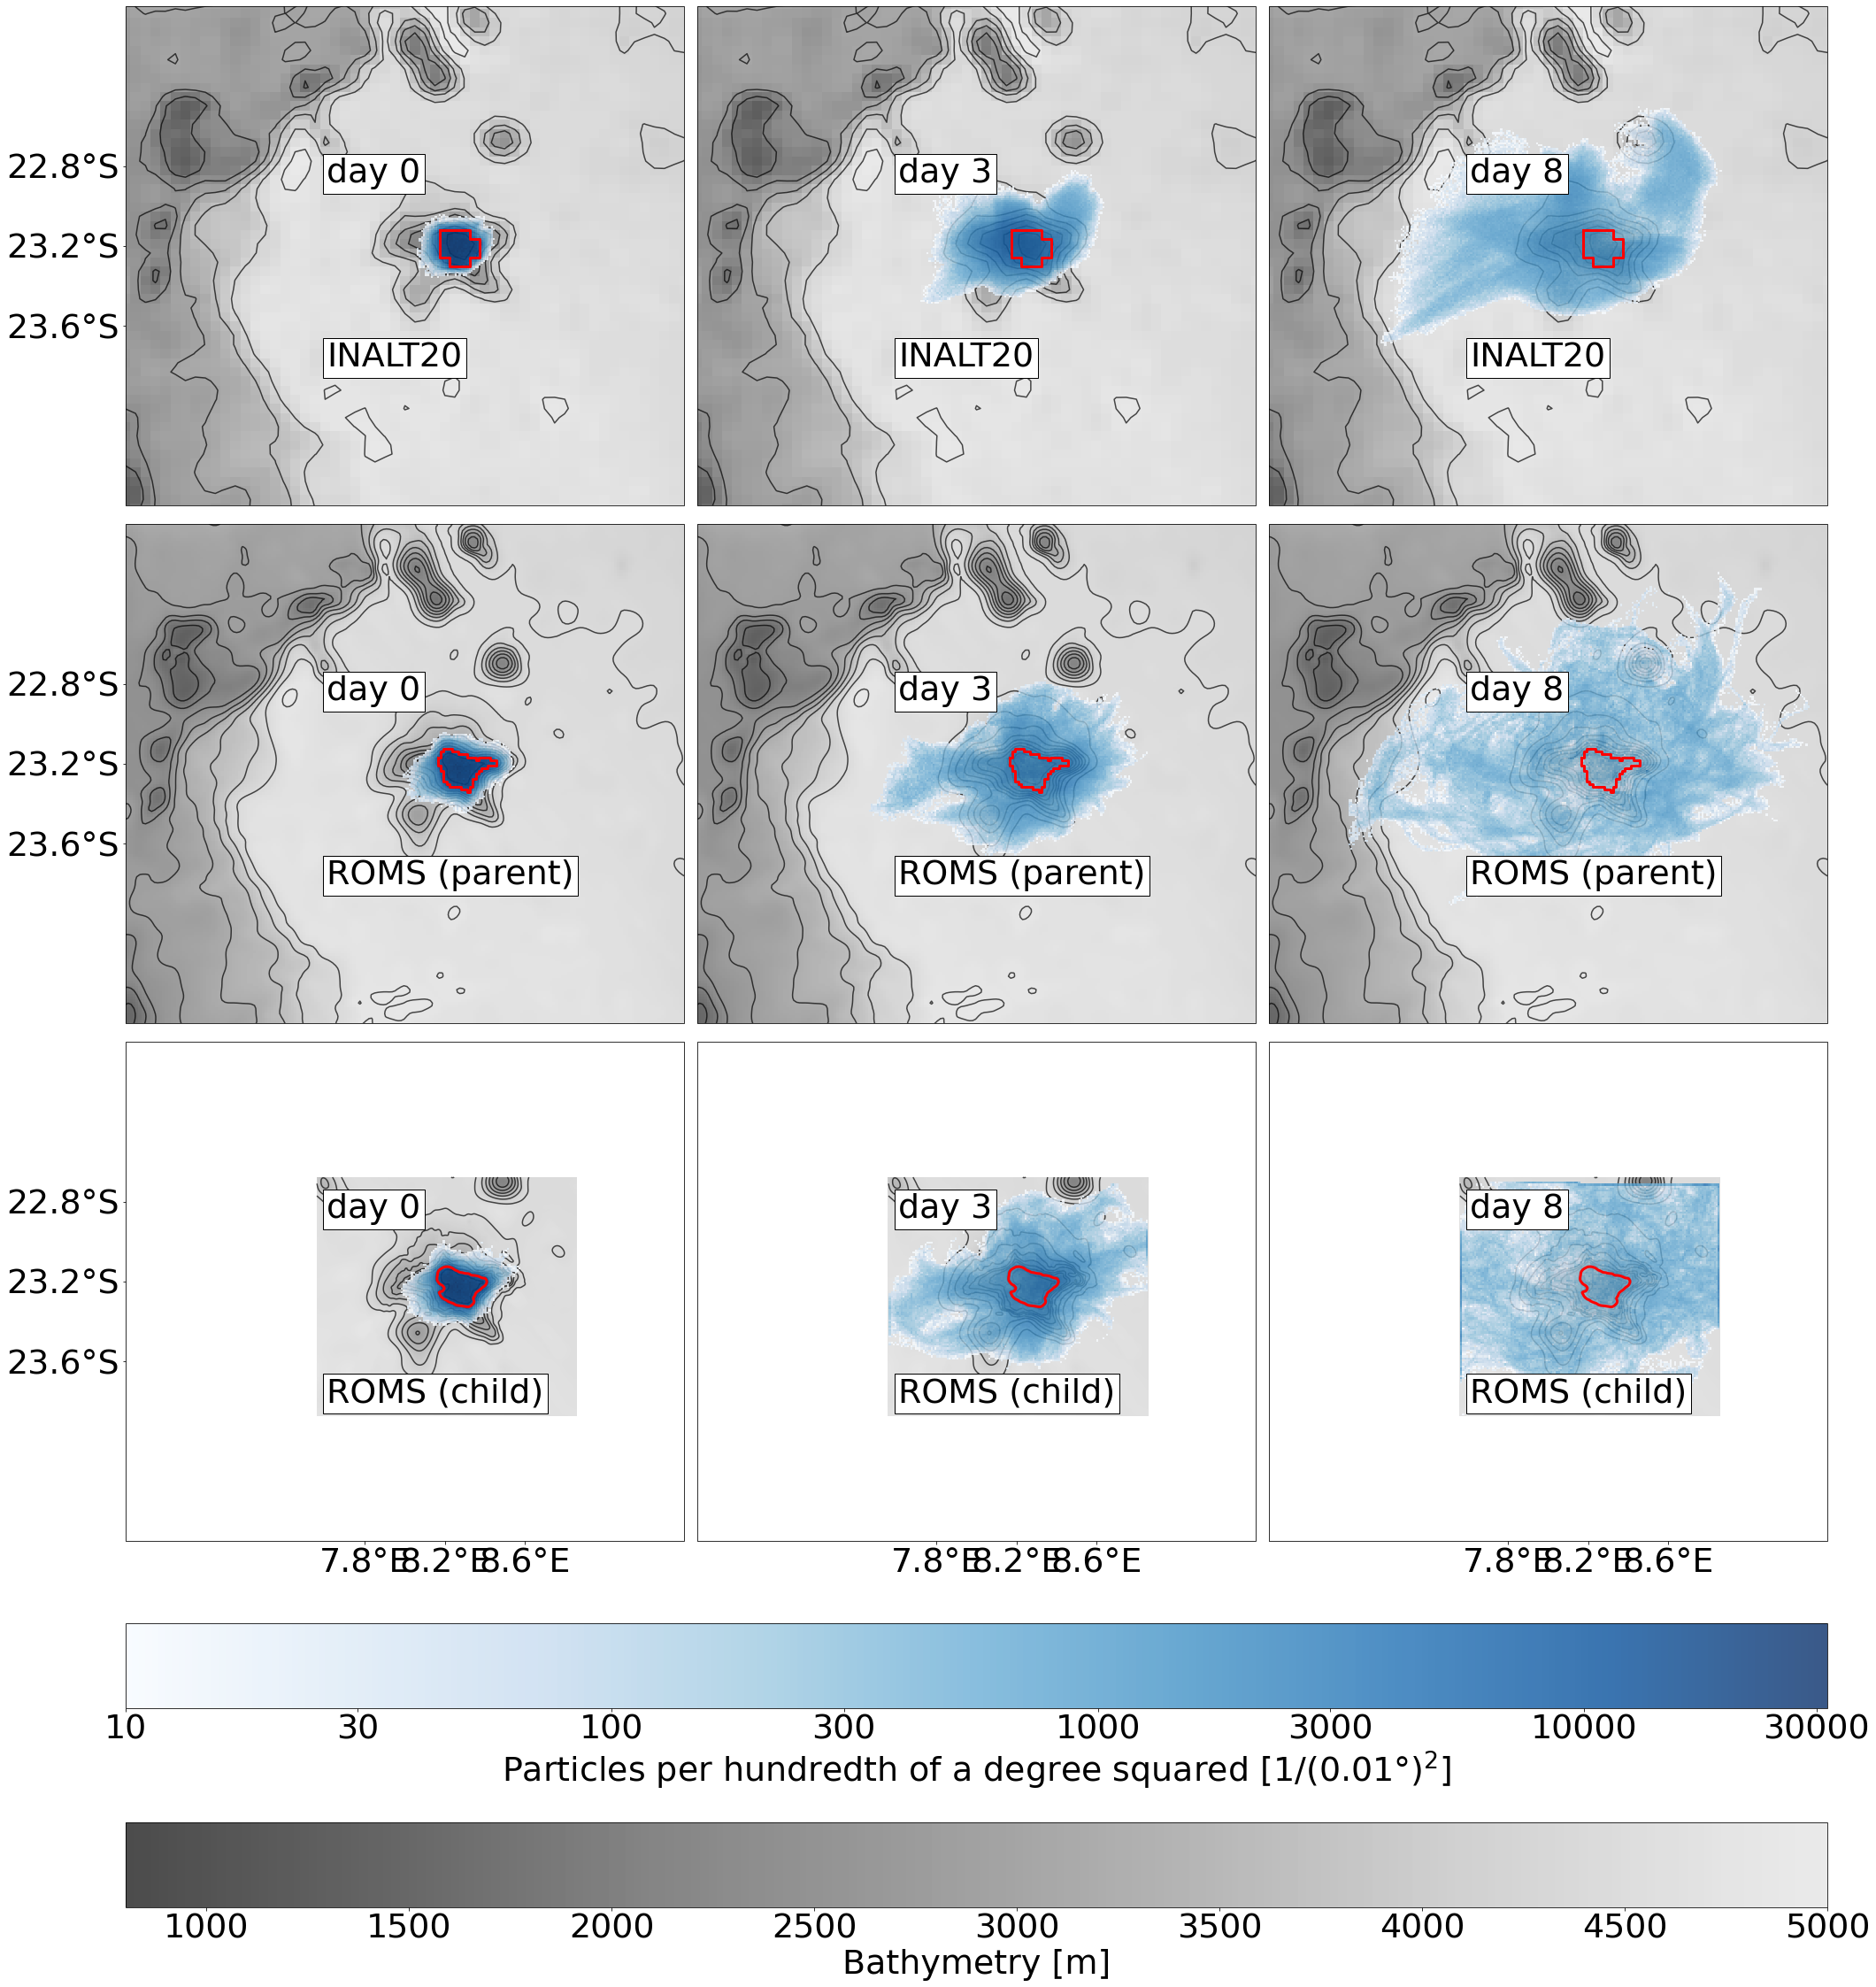

In [121]:
plt.rcParams.update({'font.size': 38})
linewidth_red = 3
extent = [6.6,9.4, -24.5,-22]
obs_1 = 3
obs_2 = 8

fig, ([ax1, ax4, ax7], [ax2, ax5, ax8], [ax3, ax6, ax9]) = plt.subplots(3,3,figsize=(30,31),constrained_layout=True,
                      subplot_kw=dict(projection=ccrs.PlateCarree()))

ax1.set_extent(extent, crs=ccrs.PlateCarree())
cf=ax1.pcolormesh(INALT_mask.glamt[0,0,:],INALT_mask.gphit[0,:,0],
             topo_INALT,vmin=800,vmax=5000,#levels=22,
             alpha=0.7,zorder=0,cmap=new_cmap_bathy)
c=ax1.contour(INALT_mask.glamt[0,0,:],INALT_mask.gphit[0,:,0],
             topo_INALT,vmin=1000,vmax=5500,levels=10,
             alpha=0.7,zorder=1,colors='black')
cfh=ax1.pcolormesh(heat_map.lon_bin,heat_map.lat_bin,np.log10(heat_map_INALT_ML.isel(obs=0).T),cmap=new_cmap,zorder=2,alpha=0.8,vmax=3.5)#,levels=np.linspace(0,3.5,8))
ax1.plot(x, y, color='red',linewidth=linewidth_red)

ax1.set_xticks([])
ax1.set_yticks([-23.6,-23.2,-22.8])
ax1.set_yticklabels(['23.6°S', '23.2°S', '22.8°S'])

ax1.text(*(7.609, -23.841),'INALT20', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))
ax1.text(*(7.609, -22.759),'day 0', ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black'))

############################################################################

ax2.set_extent(extent, crs=ccrs.PlateCarree())
cf=ax2.pcolormesh(SIGMA.lon_rho,SIGMA.lat_rho,SIGMA.h,
                vmin=800,vmax=5000,alpha=0.7,zorder=0,cmap=new_cmap_bathy)
c=ax2.contour(SIGMA.lon_rho,SIGMA.lat_rho,SIGMA.h,
              vmin=1000,vmax=5500,levels=10,alpha=0.7,zorder=1,colors='black')
cfh=ax2.pcolormesh(heat_map_ROMS.lon_bin,heat_map_ROMS.lat_bin,np.log10(heat_map_ROMS_ML.isel(obs=0).T),cmap=new_cmap,zorder=2,alpha=0.8,vmax=3.5)#,levels=np.linspace(0,3.5,8))
ax2.plot(x_ROMS, y_ROMS, color='red',linewidth=linewidth_red)

ax2.set_xticks([])
ax2.set_yticks([-23.6,-23.2,-22.8])
ax2.set_yticklabels(['23.6°S', '23.2°S', '22.8°S'])

ax2.text(*(7.609, -23.841),'ROMS (parent)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))
ax2.text(*(7.609, -22.759),'day 0', ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black'))

############################################################################

ax3.set_extent([7.6,8.8,
               -23.85,-22.75], crs=ccrs.PlateCarree())
cf=ax3.pcolormesh(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
                vmin=800,vmax=5000,alpha=0.7,zorder=0,cmap=new_cmap_bathy)
c=ax3.contour(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
              vmin=1000,vmax=5500,levels=10,alpha=0.7,zorder=1,colors='black')
cfh=ax3.pcolormesh(heat_map_ROMSchild.lon_bin,heat_map_ROMSchild.lat_bin,np.log10(heat_map_ROMSchild_ML.isel(obs=0).T),cmap=new_cmap,zorder=2,alpha=0.8,vmax=3.5)#,levels=np.linspace(0,3.5,8))
ax3.contour(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
              levels=[1500],zorder=3,colors='red',linewidths=linewidth_red)

ax3.set_xticks([7.8,8.2,8.6])
ax3.set_xticklabels(['7.8°E','8.2°E','8.6°E'])
ax3.set_yticks([-23.6,-23.2,-22.8])
ax3.set_yticklabels(['23.6°S', '23.2°S', '22.8°S'])

ax3.text(*(7.609, -23.841),'ROMS (child)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))
ax3.text(*(7.609, -22.759),'day 0', ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black'))

############################################################################

ax4.set_extent(extent, crs=ccrs.PlateCarree())
cf=ax4.pcolormesh(INALT_mask.glamt[0,0,:],INALT_mask.gphit[0,:,0],
             topo_INALT,vmin=800,vmax=5000,#levels=22,
             alpha=0.7,zorder=0,cmap=new_cmap_bathy)
c=ax4.contour(INALT_mask.glamt[0,0,:],INALT_mask.gphit[0,:,0],
             topo_INALT,vmin=1000,vmax=5500,levels=10,
             alpha=0.7,zorder=1,colors='black')
cfh=ax4.pcolormesh(heat_map.lon_bin,heat_map.lat_bin,np.log10(heat_map_INALT_ML.isel(obs=obs_1).T),cmap=new_cmap,zorder=2,alpha=0.8,vmax=3.5)#,levels=np.linspace(0,3.5,8))
ax4.plot(x, y, color='red',linewidth=linewidth_red)

ax4.set_xticks([])
ax4.set_yticks([])

ax4.text(*(7.609, -23.841),'INALT20', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))
ax4.text(*(7.609, -22.759),f'day {obs_1}', ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black'))

############################################################################

ax5.set_extent(extent, crs=ccrs.PlateCarree())
cf=ax5.pcolormesh(SIGMA.lon_rho,SIGMA.lat_rho,SIGMA.h,
                vmin=800,vmax=5000,alpha=0.7,zorder=0,cmap=new_cmap_bathy)
c=ax5.contour(SIGMA.lon_rho,SIGMA.lat_rho,SIGMA.h,
              vmin=1000,vmax=5500,levels=10,alpha=0.7,zorder=1,colors='black')
cfh=ax5.pcolormesh(heat_map_ROMS.lon_bin,heat_map_ROMS.lat_bin,np.log10(heat_map_ROMS_ML.isel(obs=obs_1).T),cmap=new_cmap,zorder=2,alpha=0.8,vmax=3.5)#,levels=np.linspace(0,3.5,8))
ax5.plot(x_ROMS, y_ROMS, color='red',linewidth=linewidth_red)

ax5.set_xticks([])
ax5.set_yticks([])

ax5.text(*(7.609, -23.841),'ROMS (parent)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))
ax5.text(*(7.609, -22.759),f'day {obs_1}', ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black'))

############################################################################

ax6.set_extent([7.6,8.8,
               -23.85,-22.75], crs=ccrs.PlateCarree())
cf=ax6.pcolormesh(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
                vmin=800,vmax=5000,alpha=0.7,zorder=0,cmap=new_cmap_bathy)
c=ax6.contour(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
              vmin=1000,vmax=5500,levels=10,alpha=0.7,zorder=1,colors='black')
cfh=ax6.pcolormesh(heat_map_ROMSchild.lon_bin,heat_map_ROMSchild.lat_bin,np.log10(heat_map_ROMSchild_ML.isel(obs=obs_1).T),cmap=new_cmap,zorder=2,alpha=0.8,vmax=3.5)#,levels=np.linspace(0,3.5,8))
ax6.contour(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
              levels=[1500],zorder=3,colors='red',linewidths=linewidth_red)

ax6.set_xticks([7.8,8.2,8.6])
ax6.set_xticklabels(['7.8°E','8.2°E','8.6°E'])
ax6.set_yticks([])

ax6.text(*(7.609, -23.841),'ROMS (child)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))
ax6.text(*(7.609, -22.759),f'day {obs_1}', ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black'))

#############################################################################

ax7.set_extent(extent, crs=ccrs.PlateCarree())
cf=ax7.pcolormesh(INALT_mask.glamt[0,0,:],INALT_mask.gphit[0,:,0],
             topo_INALT,vmin=800,vmax=5000,#levels=22,
             alpha=0.7,zorder=0,cmap=new_cmap_bathy)
c=ax7.contour(INALT_mask.glamt[0,0,:],INALT_mask.gphit[0,:,0],
             topo_INALT,vmin=1000,vmax=5500,levels=10,
             alpha=0.7,zorder=1,colors='black')
cfh=ax7.pcolormesh(heat_map.lon_bin,heat_map.lat_bin,np.log10(heat_map_INALT_ML.isel(obs=obs_2).T),cmap=new_cmap,zorder=2,alpha=0.8,vmax=3.5)#,levels=np.linspace(0,3.5,8))
ax7.plot(x, y, color='red',linewidth=linewidth_red)

ax7.set_xticks([])
ax7.set_yticks([])

ax7.text(*(7.609, -23.841),'INALT20', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))
ax7.text(*(7.609, -22.759),f'day {obs_2}', ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black'))

############################################################################

ax8.set_extent(extent, crs=ccrs.PlateCarree())
cf=ax8.pcolormesh(SIGMA.lon_rho,SIGMA.lat_rho,SIGMA.h,
                vmin=800,vmax=5000,alpha=0.7,zorder=0,cmap=new_cmap_bathy)
c=ax8.contour(SIGMA.lon_rho,SIGMA.lat_rho,SIGMA.h,
              vmin=1000,vmax=5500,levels=10,alpha=0.7,zorder=1,colors='black')
cfh=ax8.pcolormesh(heat_map_ROMS.lon_bin,heat_map_ROMS.lat_bin,np.log10(heat_map_ROMS_ML.isel(obs=obs_2).T),cmap=new_cmap,zorder=2,alpha=0.8,vmax=3.5)#,levels=np.linspace(0,3.5,8))
ax8.plot(x_ROMS, y_ROMS, color='red',linewidth=linewidth_red)

ax8.set_xticks([])
ax8.set_yticks([])

ax8.text(*(7.609, -23.841),'ROMS (parent)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))
ax8.text(*(7.609, -22.759),f'day {obs_2}', ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black'))

############################################################################

ax9.set_extent([7.6,8.8,
               -23.85,-22.75], crs=ccrs.PlateCarree())
cf=ax9.pcolormesh(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
                vmin=800,vmax=5000,alpha=0.7,zorder=0,cmap=new_cmap_bathy)
c=ax9.contour(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
              vmin=1000,vmax=5500,levels=10,alpha=0.7,zorder=1,colors='black')
cfh=ax9.pcolormesh(heat_map_ROMSchild.lon_bin,heat_map_ROMSchild.lat_bin,np.log10(heat_map_ROMSchild_ML.isel(obs=obs_2).T),cmap=new_cmap,zorder=2,alpha=0.8,vmax=3.5)#,levels=np.linspace(0,3.5,8))
ax9.contour(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
              levels=[1500],zorder=3,colors='red',linewidths=linewidth_red)

ax9.set_xticks([7.8,8.2,8.6])
ax9.set_xticklabels(['7.8°E','8.2°E','8.6°E'])
ax9.set_yticks([])
ax9.text(*(7.609, -23.841),'ROMS (child)', ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black'))
ax9.text(*(7.609, -22.759),f'day {obs_2}', ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black'))


cb=plt.colorbar(cf, ax=[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9], orientation='horizontal', pad=0.02)
cb.set_label('Bathymetry [m]')
cb_contourf = plt.colorbar(cfh, ax=[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9], orientation='horizontal', pad=0.02)
cb_contourf.set_label('Particles per hundredth of a degree squared [1/(0.01°)$^2$]')
cb_contourf.set_ticks([0,0.4771212547196624,1,1.4771212547196624,2,2.4771212547196624,3,3.4771212547196624])
cb_contourf.set_ticklabels([10,30,100,300,1000,3000,10000,30000])

#plt.savefig('../output_data/heatmaps_ML.png', bbox_inches='tight')

plt.show()

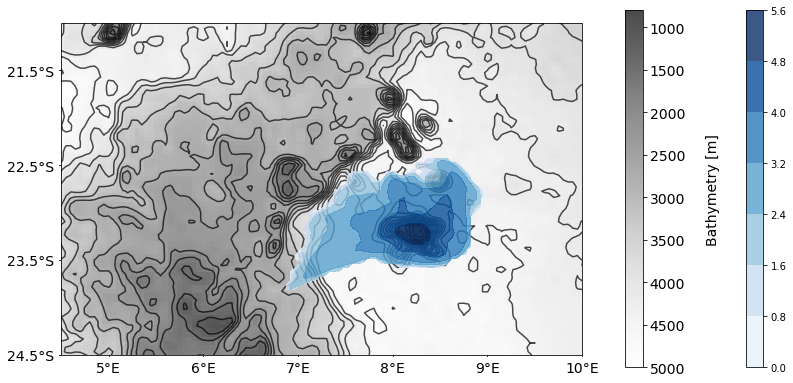

In [14]:
fig, ax = plt.subplots(1,1,figsize=(11,10),constrained_layout=True,
                      subplot_kw=dict(projection=ccrs.PlateCarree()))

ax.set_extent([4.5,10,
               -24.5,-21], crs=ccrs.PlateCarree())
cf=plt.pcolormesh(INALT_mask.glamt[0,0,:],INALT_mask.gphit[0,:,0],
             topo_INALT,vmin=800,vmax=5000,#levels=22,
             alpha=0.7,zorder=0,cmap='Greys_r')
c=plt.contour(INALT_mask.glamt[0,0,:],INALT_mask.gphit[0,:,0],
             topo_INALT,vmin=800,vmax=5000,levels=22,
             alpha=0.7,zorder=1,colors='black')
#ax.clabel(c, c.levels, inline=True, fontsize=6,fmt=fmt, colors= 'black')
cfh=plt.contourf(heat_map.lon_bin,heat_map.lat_bin,np.log10(heat_map.isel(obs=10).T),cmap='Blues',zorder=2,alpha=0.8,vmax=5)
cb_contourf = fig.colorbar(cfh, shrink=0.5)
cb=fig.colorbar(cf,shrink=0.5)
cb.ax.invert_yaxis()
cb.ax.tick_params(labelsize=14)
cb.ax.set_ylabel('\nBathymetry [m]',fontsize=14)
ax.set_xticks([5,6,7,8,9,10])
ax.set_xticklabels(['5°E','6°E','7°E','8°E','9°E','10°E'], fontsize=14, family='Arial', backgroundcolor='white')
ax.set_yticks([-24.5,-23.5,-22.5,-21.5])
ax.set_yticklabels(['24.5°S', '23.5°S', '22.5°S', '21.5°S'], fontsize=14, family='Arial', backgroundcolor='white');

In [15]:
# Create a function to generate each frame
def create_frame(frame_number):
    fig, ax = plt.subplots(1, 1, figsize=(11, 10), constrained_layout=True,
                          subplot_kw=dict(projection=ccrs.PlateCarree()))
    
    ax.set_extent([4.5, 10, -24.5, -21], crs=ccrs.PlateCarree())
    plt.pcolormesh(INALT_mask.glamt[0,0,:],INALT_mask.gphit[0,:,0],
             topo_INALT,vmin=800,vmax=5000,
             alpha=0.7,zorder=0,cmap='Greys_r')
    plt.contour(INALT_mask.glamt[0,0,:],INALT_mask.gphit[0,:,0],
             topo_INALT,vmin=800,vmax=5000,levels=22,
             alpha=0.7,zorder=1,colors='black')
    plt.contourf(heat_map.lon_bin, heat_map.lat_bin, np.log10(heat_map.isel(obs=frame_number).T), cmap='Blues',zorder=2,alpha=0.8)
    
    ax.set_xticks([5,6,7,8,9,10])
    ax.set_xticklabels(['5°E','6°E','7°E','8°E','9°E','10°E'], fontsize=14, family='Arial', backgroundcolor='white')
    ax.set_yticks([-24.5,-23.5,-22.5,-21.5])
    ax.set_yticklabels(['24.5°S', '23.5°S', '22.5°S', '21.5°S'], fontsize=14, family='Arial', backgroundcolor='white')
    
    plt.title(f'{frame_number} days after release', backgroundcolor='white')
    
    # Save the plot as an image
    plt.savefig(f'frame_{frame_number}.png', format='png')
    plt.close()

# Create the frames
num_frames = 42 
for frame_number in range(num_frames):
    create_frame(frame_number)

# Convert frames to a GIF
images = [Image.open(f'frame_{frame_number}.png') for frame_number in range(num_frames)]
images[0].save('heatmapdispersal_INALT.gif', save_all=True, append_images=images[1:], duration=500, loop=0)

# Clean up temporary images
for frame_number in range(num_frames):
    file_name = f'frame_{frame_number}.png'
    os.remove(file_name)


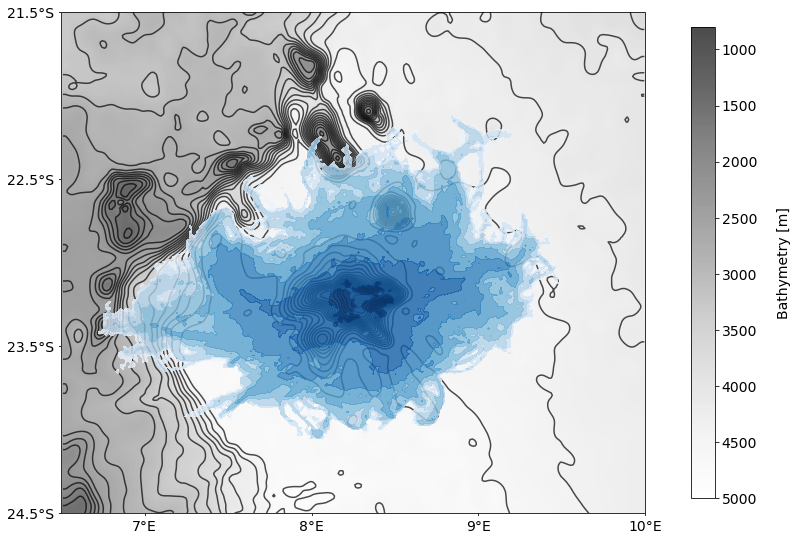

In [26]:
fig, ax = plt.subplots(1,1,figsize=(11,10),constrained_layout=True,
                      subplot_kw=dict(projection=ccrs.PlateCarree()))

ax.set_extent([7,10,
               -24.5,-21.5], crs=ccrs.PlateCarree())
cf=plt.pcolormesh(SIGMA.lon_rho,SIGMA.lat_rho,SIGMA.h,
                vmin=800,vmax=5000,alpha=0.7,zorder=0,cmap='Greys_r')
c=plt.contour(SIGMA.lon_rho,SIGMA.lat_rho,SIGMA.h,
              vmin=800,vmax=5000,levels=22,alpha=0.7,zorder=1,colors='black')
cb=fig.colorbar(cf,shrink=0.66)
cb.ax.invert_yaxis()
cb.ax.tick_params(labelsize=14)
cb.ax.set_ylabel('\nBathymetry [m]',fontsize=14)
#ax.clabel(c, c.levels, inline=True, fontsize=6,fmt=fmt, colors= 'black')
plt.contourf(heat_map_ROMS.lon_bin,heat_map_ROMS.lat_bin,np.log10(heat_map_ROMS.isel(obs=10).T),cmap='Blues',zorder=2,alpha=0.8)
ax.set_xticks([7,8,9,10])
ax.set_xticklabels(['7°E','8°E','9°E','10°E'], fontsize=14, family='Arial', backgroundcolor='white')
ax.set_yticks([-24.5,-23.5,-22.5,-21.5])
ax.set_yticklabels(['24.5°S', '23.5°S', '22.5°S', '21.5°S'], fontsize=14, family='Arial', backgroundcolor='white');

In [27]:
# Create a function to generate each frame
def create_frame(frame_number):
    fig, ax = plt.subplots(1, 1, figsize=(11, 10), constrained_layout=True,
                          subplot_kw=dict(projection=ccrs.PlateCarree()))
    
    ax.set_extent([6.5, 10, -24.5, -21.5], crs=ccrs.PlateCarree())
    plt.pcolormesh(SIGMA.lon_rho,SIGMA.lat_rho,SIGMA.h,
                vmin=800,vmax=5000,alpha=0.7,zorder=0,cmap='Greys_r')
    plt.contour(SIGMA.lon_rho,SIGMA.lat_rho,SIGMA.h,
              vmin=800,vmax=5000,levels=22,alpha=0.7,zorder=1,colors='black')
    plt.contourf(heat_map_ROMS.lon_bin,heat_map_ROMS.lat_bin,np.log10(heat_map_ROMS.isel(obs=frame_number).T),cmap='Blues',zorder=2,alpha=0.8)
    
    ax.set_xticks([7,8,9,10])
    ax.set_xticklabels(['7°E','8°E','9°E','10°E'], fontsize=14, family='Arial', backgroundcolor='white')
    ax.set_yticks([-24.5,-23.5,-22.5,-21.5])
    ax.set_yticklabels(['24.5°S', '23.5°S', '22.5°S', '21.5°S'], fontsize=14, family='Arial', backgroundcolor='white')
    
    plt.title(f'{frame_number} days after release', backgroundcolor='white')
    
    # Save the plot as an image
    plt.savefig(f'frameROMS_{frame_number}.png', format='png')
    plt.close()

# Create the frames
num_frames = 21 
for frame_number in range(num_frames):
    create_frame(frame_number)

# Convert frames to a GIF
images = [Image.open(f'frameROMS_{frame_number}.png') for frame_number in range(num_frames)]
images[0].save('heatmapdispersal_ROMS.gif', save_all=True, append_images=images[1:], duration=750, loop=0)

# Clean up temporary images
for frame_number in range(num_frames):
    file_name = f'frameROMS_{frame_number}.png'
    os.remove(file_name)


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


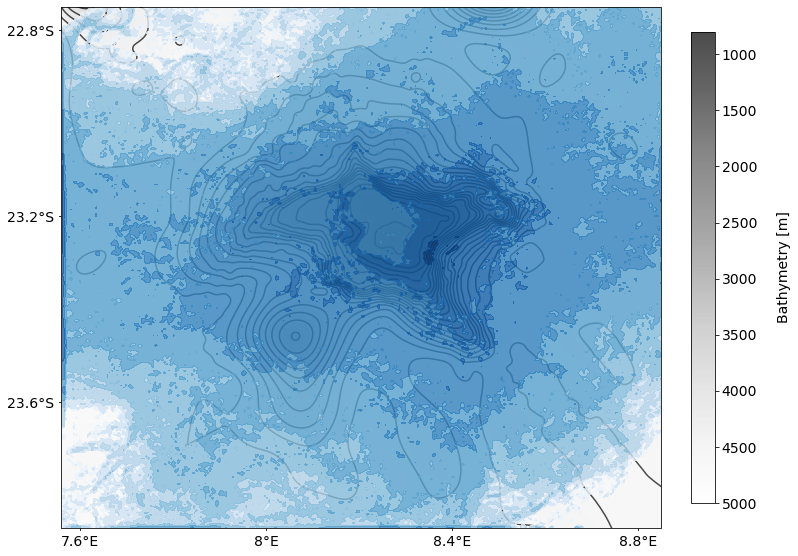

In [122]:
fig, ax = plt.subplots(1,1,figsize=(11,10),constrained_layout=True,
                      subplot_kw=dict(projection=ccrs.PlateCarree()))

ax.set_extent([7.56,8.85,
               -23.87,-22.75], crs=ccrs.PlateCarree())
cf=plt.pcolormesh(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
                vmin=800,vmax=5000,alpha=0.7,zorder=0,cmap='Greys_r')
c=plt.contour(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
              vmin=800,vmax=5000,levels=22,alpha=0.7,zorder=1,colors='black')
cb=fig.colorbar(cf,shrink=0.66)
cb.ax.invert_yaxis()
cb.ax.tick_params(labelsize=14)
cb.ax.set_ylabel('\nBathymetry [m]',fontsize=14)
#ax.clabel(c, c.levels, inline=True, fontsize=6,fmt=fmt, colors= 'black')
plt.contourf(heat_map_ROMSchild.lon_bin,heat_map_ROMSchild.lat_bin,np.log10(heat_map_ROMSchild.isel(obs=10).T),cmap='Blues',zorder=2,alpha=0.8)
ax.set_xticks([7.6,8,8.4,8.8])
ax.set_xticklabels(['7.6°E','8°E','8.4°E','8.8°E'], fontsize=14, family='Arial', backgroundcolor='white')
ax.set_yticks([-23.6,-23.2,-22.8])
ax.set_yticklabels(['23.6°S', '23.2°S', '22.8°S'], fontsize=14, family='Arial', backgroundcolor='white');

In [125]:
# Create a function to generate each frame
def create_frame(frame_number):
    fig, ax = plt.subplots(1, 1, figsize=(11, 10), constrained_layout=True,
                          subplot_kw=dict(projection=ccrs.PlateCarree()))
    
    ax.set_extent([7.56,8.85,
               -23.87,-22.75], crs=ccrs.PlateCarree())
    plt.pcolormesh(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
                vmin=800,vmax=5000,alpha=0.7,zorder=0,cmap='Greys_r')
    plt.contour(SIGMAchild.lon_rho,SIGMAchild.lat_rho,SIGMAchild.h,
              vmin=800,vmax=5000,levels=22,alpha=0.7,zorder=1,colors='black')
    plt.contourf(heat_map_ROMSchild.lon_bin,heat_map_ROMSchild.lat_bin,np.log10(heat_map_ROMSchild.isel(obs=frame_number).T),cmap='Blues',zorder=2,alpha=0.8)
    
    ax.set_xticks([7.6,8,8.4,8.8])
    ax.set_xticklabels(['7.6°E','8°E','8.4°E','8.8°E'], fontsize=14, family='Arial', backgroundcolor='white')
    ax.set_yticks([-23.6,-23.2,-22.8])
    ax.set_yticklabels(['23.6°S', '23.2°S', '22.8°S'], fontsize=14, family='Arial', backgroundcolor='white')
    
    plt.title(f'{frame_number} days after release', backgroundcolor='white')
    
    # Save the plot as an image
    plt.savefig(f'frameROMSc_{frame_number}.png', format='png')
    plt.close()

# Create the frames
num_frames = 10 
for frame_number in range(num_frames):
    create_frame(frame_number)

# Convert frames to a GIF
images = [Image.open(f'frameROMSc_{frame_number}.png') for frame_number in range(num_frames)]
images[0].save('heatmapdispersal_ROMSchild.gif', save_all=True, append_images=images[1:], duration=1000, loop=0)

# Clean up temporary images
for frame_number in range(num_frames):
    file_name = f'frameROMSc_{frame_number}.png'
    os.remove(file_name)


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/opt

In [133]:
depths = np.arange(0,2000,15)

In [184]:
heat_map_depth = xhist(particle_ds.lon, particle_ds.z, bins=[lons, depths], dim=["traj", ])
heat_map_depth_ROMS = xhist(ROMS_ds.lon, ROMS_ds.z, bins=[lons_ROMS, depths], dim=["traj", ])
heat_map_depth_ROMS_child = xhist(ROMSchild_ds.lon, ROMSchild_ds.z, bins=[lons_ROMSchild, depths], dim=["traj", ])

/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


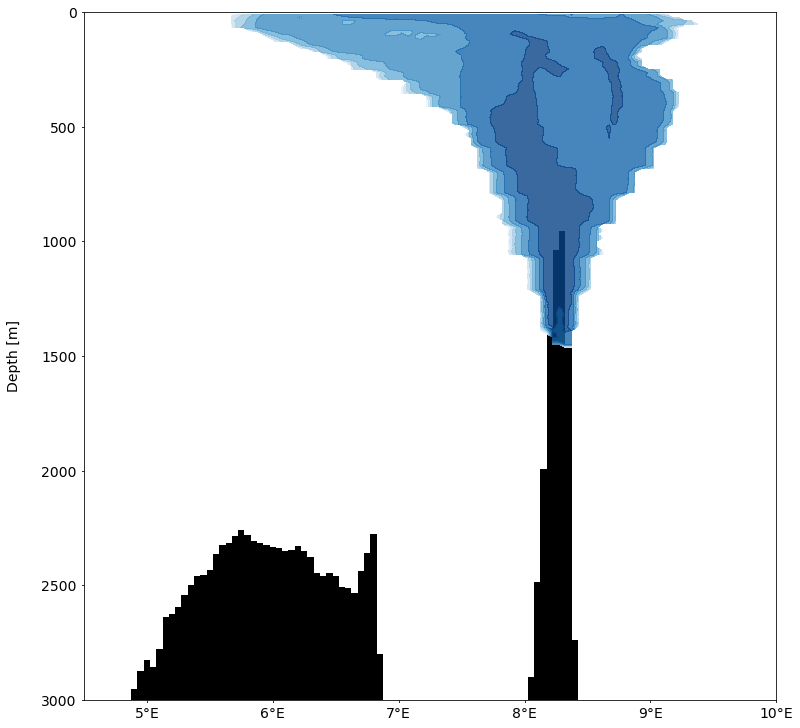

In [180]:
fig, ax = plt.subplots(1,1,figsize=(11,10),constrained_layout=True)

ax.set_xlim([4.5,10])
ax.set_ylim([INALT_levels.max().values-3000,INALT_levels.max().values])

plt.bar(np.linspace(0,18.05,362),topo_INALT_bar,width=0.05,label='INALT',color='black')
plt.contourf(heat_map_depth.lon_bin,-heat_map_depth.z_bin+INALT_levels.max().values,
             np.log10(heat_map_depth.isel(obs=20).T),cmap='Blues',zorder=2,alpha=0.8)
ax.set_xticks([5,6,7,8,9,10])
ax.set_xticklabels(['5°E','6°E','7°E','8°E','9°E','10°E'], fontsize=14, family='Arial', backgroundcolor='white')
ax.set_yticks(np.linspace(INALT_levels.max()-3000,INALT_levels.max(),7))
ax.set_yticklabels([int(i) for i in np.linspace(3000,0,7)],fontsize=14, backgroundcolor='white')
ax.set_ylabel('Depth [m]\n',fontsize=14, family='Arial');

In [186]:
# Create a function to generate each frame
def create_frame(frame_number):
    fig, ax = plt.subplots(1, 1, figsize=(11, 10), constrained_layout=True)
    ax.set_xlim([4.5, 10])
    ax.set_ylim([INALT_levels.max().values - 3000, INALT_levels.max().values])

    plt.bar(np.linspace(0, 18.05, 362), topo_INALT_bar, width=0.05, label='INALT', color='black')
    plt.contourf(heat_map_depth.lon_bin, -heat_map_depth.z_bin + INALT_levels.max().values,
                 np.log10(heat_map_depth.isel(obs=frame_number).T), cmap='Blues', zorder=2, alpha=0.8)

    ax.set_xticks([5, 6, 7, 8, 9, 10])
    ax.set_xticklabels(['5°E', '6°E', '7°E', '8°E', '9°E', '10°E'], fontsize=14, family='Arial', backgroundcolor='white')
    
    ax.set_yticks(np.linspace(INALT_levels.max() - 3000, INALT_levels.max(), 7))
    ax.set_yticklabels([int(i) for i in np.linspace(3000, 0, 7)], fontsize=14, backgroundcolor='white')
    ax.set_ylabel('Depth [m]\n',fontsize=14, family='Arial', backgroundcolor='white')

    plt.title(f'{frame_number} days after release', backgroundcolor='white')

    # Save the plot as an image
    plt.savefig(f'frameINALTd_{frame_number}.png', format='png')
    plt.close()

# Create the frames
num_frames = 42  # Replace with the number of frames you have
for frame_number in range(num_frames):
    create_frame(frame_number)

# Convert frames to a GIF
images = [Image.open(f'frameINALTd_{frame_number}.png') for frame_number in range(num_frames)]
images[0].save('heatmapdispersal_INALT_depth.gif', save_all=True, append_images=images[1:], duration=500, loop=0)

# Clean up temporary images
for frame_number in range(num_frames):
    file_name = f'frameINALTd_{frame_number}.png'
    os.remove(file_name)

/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/opt

/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


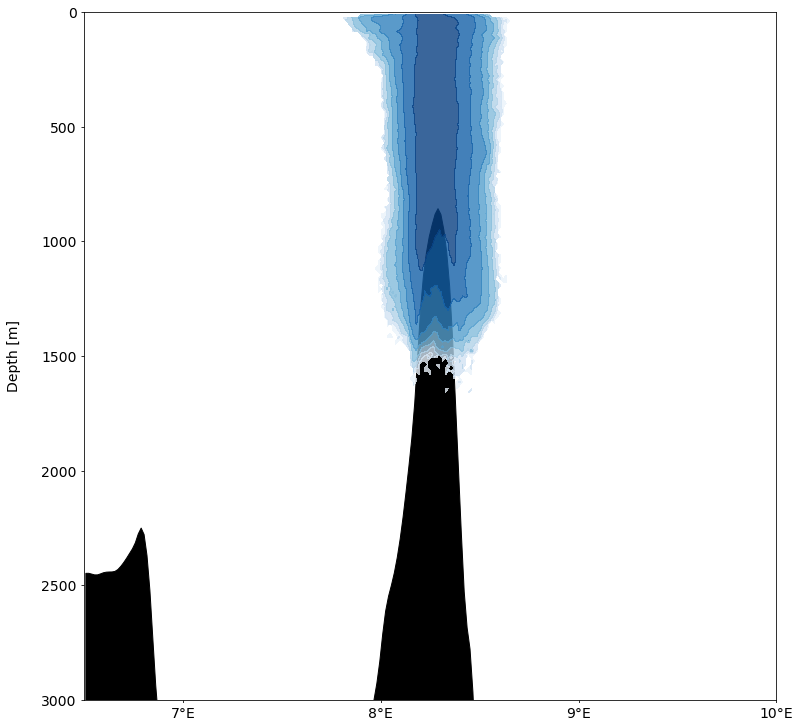

In [182]:
fig, ax = plt.subplots(1,1,figsize=(11,10),constrained_layout=True)

ax.set_xlim([6.5,10])
ax.set_ylim([ROMS_levels.max().values-3000,ROMS_levels.max().values])
plt.fill_between(np.linspace(6.51,9.995925,238), 0, topo_ROMS_bar,color='black',label='ROMS parent')
plt.contourf(heat_map_depth_ROMS.lon_bin,-heat_map_depth_ROMS.z_bin+ROMS_levels.max(),
             np.log10(heat_map_depth_ROMS.isel(obs=1).T),cmap='Blues',zorder=2,alpha=0.8)
ax.set_xticks([7,8,9,10])
ax.set_xticklabels(['7°E','8°E','9°E','10°E'], fontsize=14, family='Arial', backgroundcolor='white')
ax.set_yticks(np.linspace(ROMS_levels.max()-3000,ROMS_levels.max(),7),[int(i) for i in np.linspace(3000,0,7)],fontsize=14)
ax.set_ylabel('Depth [m]\n',fontsize=14, family='Arial');

In [185]:
def create_frame(frame_number):
    fig, ax = plt.subplots(1, 1, figsize=(11, 10), constrained_layout=True)
    ax.set_xlim([6.5, 10])
    ax.set_ylim([ROMS_levels.max().values - 3000, ROMS_levels.max().values])

    plt.fill_between(np.linspace(6.51, 9.995925, 238), 0, topo_ROMS_bar, color='black', label='ROMS parent')
    plt.contourf(heat_map_depth_ROMS.lon_bin, -heat_map_depth_ROMS.z_bin + ROMS_levels.max(),
                 np.log10(heat_map_depth_ROMS.isel(obs=frame_number).T), cmap='Blues', zorder=2, alpha=0.8)

    ax.set_xticks([7, 8, 9, 10])
    ax.set_xticklabels(['7°E', '8°E', '9°E', '10°E'], fontsize=14, family='Arial', backgroundcolor='white')
    ax.set_ylabel('Depth [m]\n',fontsize=14, family='Arial', backgroundcolor='white')

    y_ticks = np.linspace(ROMS_levels.max() - 3000, ROMS_levels.max(), 7)
    y_tick_labels = [int(i) for i in np.linspace(3000, 0, 7)]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_tick_labels, fontsize=14, backgroundcolor='white')

    plt.title(f'{frame_number} days after release', backgroundcolor='white')

    # Save the plot as an image
    plt.savefig(f'frameROMSd_{frame_number}.png', format='png')
    plt.close()

# Create the frames
num_frames = 21  # Number of frames you want (up to 21)
for frame_number in range(num_frames):
    create_frame(frame_number)

# Convert frames to a GIF
images = [Image.open(f'frameROMSd_{frame_number}.png') for frame_number in range(num_frames)]
images[0].save('heatmapdispersal_ROMS_depth.gif', save_all=True, append_images=images[1:], duration=750, loop=0)

# Clean up temporary images
for frame_number in range(num_frames):
    file_name = f'frameROMSd_{frame_number}.png'
    os.remove(file_name)

/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/opt

In [188]:
def create_frame(frame_number):
    fig, ax = plt.subplots(1, 1, figsize=(11, 10), constrained_layout=True)
    ax.set_xlim([7.56, 8.85])
    ax.set_ylim([ROMS_child_levels.max().values - 3000, ROMS_child_levels.max().values])

    plt.fill_between(np.linspace(7.55902, 8.858039, 266), 0, topo_ROMS_child_bar, color='black', label='ROMS child')
    plt.contourf(heat_map_depth_ROMS_child.lon_bin, -heat_map_depth_ROMS_child.z_bin + ROMS_child_levels.max(),
                 np.log10(heat_map_depth_ROMS_child.isel(obs=frame_number).T), cmap='Blues', zorder=2, alpha=0.8)

    ax.set_xticks([7.6,8,8.4,8.8])
    ax.set_xticklabels(['7.6°E','8°E','8.4°E','8.8°E'], fontsize=14, family='Arial', backgroundcolor='white')
    ax.set_ylabel('Depth [m]\n',fontsize=14, family='Arial', backgroundcolor='white')

    y_ticks = np.linspace(ROMS_child_levels.max() - 3000, ROMS_child_levels.max(), 7)
    y_tick_labels = [int(i) for i in np.linspace(3000, 0, 7)]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_tick_labels, fontsize=14, backgroundcolor='white')

    plt.title(f'{frame_number} days after release', backgroundcolor='white')

    # Save the plot as an image
    plt.savefig(f'frameROMScd_{frame_number}.png', format='png')
    plt.close()

# Create the frames
num_frames = 10  # Number of frames you want (up to 21)
for frame_number in range(num_frames):
    create_frame(frame_number)

# Convert frames to a GIF
images = [Image.open(f'frameROMScd_{frame_number}.png') for frame_number in range(num_frames)]
images[0].save('heatmapdispersal_ROMSchild_depth.gif', save_all=True, append_images=images[1:], duration=1000, loop=0)

# Clean up temporary images
for frame_number in range(num_frames):
    file_name = f'frameROMScd_{frame_number}.png'
    os.remove(file_name)

/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/opt